In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import glob as glob
import os
from importlib import reload
%matplotlib inline
import sys
sys.path.append("modules")
import bedgraph_tools as bgt
import peak_tools as pkt
from collections import defaultdict
import pyBigWig as pw
from matplotlib_venn import venn2
import pysam
from itertools import groupby
from Bio import motifs
import logomaker
from Bio import Align
from Bio.Seq import Seq
%config InlineBackend.figure_format='retina'
import matplotlib
from scipy import stats
from scipy.interpolate import interp1d
matplotlib.rcParams['pdf.fonttype'] = 42
nmeta = pd.read_parquet('sample_metadata_20250211.parquet')
import matplotlib.colors as mcolors


In [2]:
aligner = Align.PairwiseAligner()


In [3]:
def load_and_add_name_col(path, name):
    pp = pr.read_bed(path)
    pp = pp.insert(pd.Series(data = np.char.add(np.arange(len(pp)).astype(str), '_{}'.format(name)), name="Column"))
    return pp

# def load_mot(path):
#     return pd.read_csv(os.path.join(path, 'fimo.tsv'), delimiter='\t').iloc[:-3,: ].loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand']]

def align_mots(ref, seq2, aligner=aligner):
    aligned_F = aligner.align(ref, seq2)
    aligned_R = aligner.align(ref, Seq(seq2).reverse_complement())
    
    if aligned_F.score >= aligned_R.score:
        return "+"
    else:
        return "-"

def load_mot(path, mot_path):
    with open(mot_path) as handle:
        cosensus_mot = motifs.read(handle, "pfm-four-columns").consensus

        # Extract the motif sequences (not specifically used below)
    loaded_loc = pd.read_csv(os.path.join(path, 'fimo.tsv'), delimiter='\t').iloc[:-3,: ]#.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'matched_sequence']]
    seqs = loaded_loc.sort_values(by='score', ascending=False).loc[:, 'matched_sequence']
#     loaded_loc['strand'] = seqs.apply(lambda x: align_mots(cosensus_mot, x, aligner)).values
    return loaded_loc

def filter_top_quantile(group, quantile=0.9):
    """
    Filters rows in a group where the sum across columns is above the quantile threshold.
    
    Parameters:
        group (pd.DataFrame): Grouped DataFrame.
        quantile (float): The quantile threshold (default 0.9).
        
    Returns:
        pd.DataFrame: Filtered DataFrame with top quantile rows.
    """
    # Compute the sum across all numeric columns per row
    row_sums = group.loc[:, list(np.arange(70,90).astype(str)) + list(np.arange(110,130).astype(str))].sum(axis=1)
    row_sums = group.loc[:, list(np.arange(200).astype(str))].sum(axis=1)

    # Compute the quantile threshold
    threshold = np.quantile(row_sums, quantile)

    # Return rows that exceed the threshold
    return group[row_sums >= threshold]

def find_gap_length(series, threshold):
    """
    Finds the length of the largest gap in the given series where values are below a threshold.

    Parameters:
    series (pd.Series): The mean signal data.
    threshold (float): The value below which the signal is considered absent.

    Returns:
    int: Length of the largest contiguous gap.
    """
    below_threshold = series < threshold  # Boolean mask where values are below the threshold
    gap_lengths = []  # Store lengths of gaps
    current_length = 0

    for is_below in below_threshold:
        if is_below:
            current_length += 1
        else:
            if current_length > 0:
                gap_lengths.append(current_length)
                current_length = 0

    if current_length > 0:  # Catch gap at the end
        gap_lengths.append(current_length)

    return max(gap_lengths, default=0)

def load_and_rename_mot(path, name):
    mot_enrich = pd.DataFrame(pd.read_csv(os.path.join(path, 'fimo.tsv'), delimiter='\t').iloc[:-3].set_index('sequence_name').loc[:, 'score']).reset_index().groupby('sequence_name').count()
    mot_enrich.columns = [name]
    return mot_enrich
def compute_footprint_lengths(x, y, thresholds):
    """
    Compute footprint lengths for multiple percentage thresholds.
    
    Parameters:
        x (array-like): X-values (time or index)
        y (array-like): Y-values (signal intensity)
        thresholds (list): List of percentage drop values (e.g., [0.05, 0.1, 0.5])

    Returns:
        footprint_lengths (dict): Dictionary with thresholds as keys and footprint lengths as values.
    """
    # Interpolation function
    interp_func = interp1d(x, y, kind='linear')

    # Generate more dense x values for interpolation
    window = 600
    x_dense = np.linspace(min(x), max(x), window)
    y_dense = interp_func(x_dense)  # Interpolated y values

    # Find Peak
    peak_index = int(window/2)
    peak_x = x_dense[peak_index]
    peak_y = y_dense[peak_index]

    footprint_lengths = {}

    for threshold in thresholds:
        threshold_value = threshold * peak_y  # Compute threshold level

        # Find left and right drop-off points safely
        left_indices = np.where(y_dense[:peak_index] <= threshold_value)[0]
        right_indices = np.where(y_dense[peak_index:] <= threshold_value)[0]

        left_x = x_dense[left_indices[-1]] if len(left_indices) > 0 else None
        right_x = x_dense[right_indices[0] + peak_index] if len(right_indices) > 0 else None

        # Compute footprint length if both sides exist
        footprint_length = right_x - left_x if left_x is not None and right_x is not None else None

        footprint_lengths[threshold] = footprint_length

    return footprint_lengths

In [4]:
# nmumg_peaks = nmeta.filter(regex='ar', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'peaks_w_summits'].values

# conc_peaks = pr.concat([load_and_add_name_col(x, x.split('/')[-1].split('_fc10')[0]) for x in nmumg_peaks])
# cluster_peaks = conc_peaks.cluster(slack=100)
# groupd_clustered = cluster_peaks.df.groupby("Cluster").agg(lambda x: list(x))
# needed_columns = groupd_clustered.loc[:, ['Chromosome', 'Start', 'End', 'Column']]
# needed_columns.loc[:, 'Chromosome'] = needed_columns.Chromosome.apply(lambda x: x[0])
# needed_columns.loc[:, 'Start'] = needed_columns.Start.apply(lambda x: np.ceil(np.mean(x))).astype(int)
# needed_columns.loc[:, 'End'] = needed_columns.End.apply(lambda x: np.ceil(np.mean(x))).astype(int)
# needed_columns.iloc[:, [0,1,2]].to_csv('cell_peaks_dbddlbdwtlig/nmumg_clustered_peak_ar_truncations.bed'
#                                        ,index=False, header=False, sep='\t')
# needed_columns.loc[:,'nindex'] = needed_columns.Chromosome.astype('str') + ':' + needed_columns.Start.astype(str) + '-' + needed_columns.End.astype(str)

# needed_columns.loc[:, 'pmiddle'] = (np.ceil((needed_columns.End - needed_columns.Start)/2) + needed_columns.Start).astype(int)

# nmumg_bws = nmeta.filter(regex='ar', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'BigWig'].to_dict()

# window = 300
# sumd = dict()
# for key, value in nmumg_bws.items():
    
#     for i, vali in enumerate(value):
        
#         print(key+str(i+1))
        
#         cbw = pw.open(vali)

#         val_list = []
#         sum_val_list = []

#         for chrom, middle in needed_columns.loc[:, ['Chromosome', 'pmiddle']].values:
#             try:
#                 vecp = cbw.values(chrom, int(middle - 1000), int(middle + 1000), numpy=True)
#                 vecs = vecp[700:1300]

#             except:
#                 vecp = np.zeros(2000)
#                 vecs = vecp[700:1300]

#             val_list.append(vecp)
#             sum_val_list.append(vecs.sum())

#         sumd[key+str(i+1)] = sum_val_list
#         sig_df = pd.DataFrame(val_list)
#         sig_df.index = needed_columns.nindex
#         sig_df.to_parquet('cell_peaks_dbddlbdwtlig/nmumg_signal_of_peaks_artruncations_repeats_{}.parquet'.format(key))

# pd.concat([needed_columns.set_index('nindex'), pd.DataFrame(sumd, index=needed_columns.nindex)], axis=1).to_parquet('cell_peaks_dbddlbdwtlig/nmumg_sumsig600bp_of_peaks_artruncations_repeats_all.parquet')



# nmumg_bws = nmeta.filter(regex='ar', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'AverageBw'].to_dict()

# window = 300
# sumd = dict()
# for key, value in nmumg_bws.items():
#     print(key)
#     cbw = pw.open(value)
    
#     val_list = []
#     sum_val_list = []
    
#     for chrom, middle in needed_columns.loc[:, ['Chromosome', 'pmiddle']].values:
#         vecp = cbw.values(chrom, int(middle - 1000), int(middle + 1000), numpy=True)
#         vecs = vecp[700:1300]
#         val_list.append(vecp)
#         sum_val_list.append(vecs.sum())
    
#     sumd[key] = sum_val_list
#     sig_df = pd.DataFrame(val_list)
#     sig_df.index = needed_columns.nindex
#     sig_df.to_parquet('cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_{}.parquet'.format(key))
    
#     pd.concat([needed_columns, pd.DataFrame(sumd, index=needed_columns.index)], axis=1).to_parquet('cell_peaks_dbddlbdwtlig/nmumg_ar_trunc_clustered_peak_wsignals.parquet')

In [5]:
mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_ar_trunc_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_ar_trunc_cluster_parsed/',
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_ar_trunc_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_ar_trunc_cluster_parsed/',               
   'cell_peaks_dbddlbdwtlig/mot_enrich/KLF_nmumg_ar_trunc_cluster_parsed/',
   'cell_peaks_dbddlbdwtlig/mot_enrich/RUNX_nmumg_ar_trunc_cluster_parsed/',
   'cell_peaks_dbddlbdwtlig/mot_enrich/TEAD_nmumg_ar_trunc_cluster_parsed/',
              ]

motd = { 'GR_halfsite':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_dbd_fc10.bed/homerResults/motif4.motif',
        'GR_NR' : 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif3.motif',
        'GR_AP1': 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif1.motif',
        'GR_FOX' : 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif5.motif', 
        'GR_KLF':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif2.motif',
    'GR_RUNX':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif6.motif',
        'GR_TEAD':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif4.motif',
      
    }
name_path_mot = dict(zip(mot_folders, motd.values()))

all_motifs = pd.concat([load_mot(x, name_path_mot[x]) for x in mot_folders])
all_motifs.loc[:, 'middle'] = np.ceil(((all_motifs.stop - all_motifs.start)/2) + all_motifs.start).astype(np.int32)
all_motifs = all_motifs.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'middle']]
all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
all_motifs.to_csv('cell_peaks_dbddlbdwtlig/nmumg_ar_truncs_motifs_location_in_peaks.csv')

bgs = nmeta.filter(regex='ar', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, ['NormBG']].T.to_dict()


procf_barebones = 'bsub -n 8 -q short -R \"span[hosts=1]\" -R \"rusage[mem=4000]\" \"python mot_analysis.py --bedgraph {blist} --motifs cell_peaks_dbddlbdwtlig/nmumg_ar_truncs_motifs_location_in_peaks.csv --output {out}\"'

for key, value in bgs.items():
    out = "cell_peaks_dbddlbdwtlig/ar_trunc_{}".format(key)
    print(procf_barebones.format(blist=' '.join(value['NormBG']), out=out))

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/NMuMG_AR_dLBD_dN100_1_S46.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/NMuMG_AR_dLBD_dN100_2_S47.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/NMuMG_AR_dLBD_dN100_3_S48.bedgraph.gz --motifs cell_peaks_dbddlbdwtlig/nmumg_ar_truncs_motifs_location_in_peaks.csv --output cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_ar_dlbd_dn100"
bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/NMuMG_AR_dLBD_dN150_1_S82.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/NMuMG_AR_dLBD_dN150_2_S83.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Da

In [6]:
# nmumg_peaks = nmeta.filter(regex='pr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'peaks_w_summits'].values

# conc_peaks = pr.concat([load_and_add_name_col(x, x.split('/')[-1].split('_fc10')[0]) for x in nmumg_peaks])
# cluster_peaks = conc_peaks.cluster(slack=100)
# groupd_clustered = cluster_peaks.df.groupby("Cluster").agg(lambda x: list(x))
# needed_columns = groupd_clustered.loc[:, ['Chromosome', 'Start', 'End', 'Column']]
# needed_columns.loc[:, 'Chromosome'] = needed_columns.Chromosome.apply(lambda x: x[0])
# needed_columns.loc[:, 'Start'] = needed_columns.Start.apply(lambda x: np.ceil(np.mean(x))).astype(int)
# needed_columns.loc[:, 'End'] = needed_columns.End.apply(lambda x: np.ceil(np.mean(x))).astype(int)
# needed_columns.iloc[:, [0,1,2]].to_csv('cell_peaks_dbddlbdwtlig/nmumg_clustered_peak_pr_truncations.bed'
#                                        ,index=False, header=False, sep='\t')
# needed_columns.loc[:,'nindex'] = needed_columns.Chromosome.astype('str') + ':' + needed_columns.Start.astype(str) + '-' + needed_columns.End.astype(str)

# needed_columns.loc[:, 'pmiddle'] = (np.ceil((needed_columns.End - needed_columns.Start)/2) + needed_columns.Start).astype(int)

# nmumg_bws = nmeta.filter(regex='pr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'BigWig'].to_dict()

# window = 300
# sumd = dict()
# for key, value in nmumg_bws.items():
    
#     for i, vali in enumerate(value):
        
#         print(key+str(i+1))
        
#         cbw = pw.open(vali)

#         val_list = []
#         sum_val_list = []

#         for chrom, middle in needed_columns.loc[:, ['Chromosome', 'pmiddle']].values:
#             try:
#                 vecp = cbw.values(chrom, int(middle - 1000), int(middle + 1000), numpy=True)
#                 vecs = vecp[700:1300]

#             except:
#                 vecp = np.zeros(2000)
#                 vecs = vecp[700:1300]

#             val_list.append(vecp)
#             sum_val_list.append(vecs.sum())

#         sumd[key+str(i+1)] = sum_val_list
#         sig_df = pd.DataFrame(val_list)
#         sig_df.index = needed_columns.nindex
#         sig_df.to_parquet('cell_peaks_dbddlbdwtlig/nmumg_signal_of_peaks_prtruncations_repeats_{}.parquet'.format(key))

# pd.concat([needed_columns.set_index('nindex'), pd.DataFrame(sumd, index=needed_columns.nindex)], axis=1).to_parquet('cell_peaks_dbddlbdwtlig/nmumg_sumsig600bp_of_peaks_prtruncations_repeats_all.parquet')



# nmumg_bws = nmeta.filter(regex='pr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'AverageBw'].to_dict()
# window = 300
# sumd = dict()
# for key, value in nmumg_bws.items():
#     print(key)
#     cbw = pw.open(value)
    
#     val_list = []
#     sum_val_list = []
    
#     for chrom, middle in needed_columns.loc[:, ['Chromosome', 'pmiddle']].values:
#         vecp = cbw.values(chrom, int(middle - 1000), int(middle + 1000), numpy=True)
#         vecs = vecp[700:1300]
#         val_list.append(vecp)
#         sum_val_list.append(vecs.sum())
    
#     sumd[key] = sum_val_list
#     sig_df = pd.DataFrame(val_list)
#     sig_df.index = needed_columns.nindex
#     sig_df.to_parquet('cell_peaks_dbddlbdwtlig/signal_of_peaks_prtruncations_{}.parquet'.format(key))
    
#     pd.concat([needed_columns, pd.DataFrame(sumd, index=needed_columns.index)], axis=1).to_parquet('cell_peaks_dbddlbdwtlig/nmumg_pr_trunc_clustered_peak_wsignals.parquet')

In [7]:
# mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_pr_trunc_cluster_parsed/', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_pr_trunc_cluster_parsed/',
# 'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_pr_trunc_cluster_parsed/', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_pr_trunc_cluster_parsed/', ]
# all_motifs = pd.concat([load_mot(x) for x in mot_folders])
# all_motifs.loc[:, 'midddle'] = np.ceil((all_motifs.stop - all_motifs.start) + all_motifs.start).astype(np.int32)
# all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
# remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
# all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
# all_motifs.to_csv('cell_peaks_dbddlbdwtlig/nmumg_pr_truncs_motifs_location_in_peaks.csv')

# bgs = nmeta.filter(regex='pr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, ['NormBG']].T.to_dict()


# procf_barebones = 'bsub -n 8 -q short -R \"span[hosts=1]\" -R \"rusage[mem=4000]\" \"python mot_analysis.py --bedgraph {blist} --motifs cell_peaks_dbddlbdwtlig/nmumg_pr_truncs_motifs_location_in_peaks.csv --output {out}\"'

# for key, value in bgs.items():
#     out = "cell_peaks_dbddlbdwtlig/pr_trunc_{}".format(key)
#     print(procf_barebones.format(blist=' '.join(value['NormBG']), out=out))

In [8]:
mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_pr_trunc_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_pr_trunc_cluster_parsed/',
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_pr_trunc_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_pr_trunc_cluster_parsed/',   
               'cell_peaks_dbddlbdwtlig/mot_enrich/KLF_nmumg_pr_trunc_cluster_parsed/',
   'cell_peaks_dbddlbdwtlig/mot_enrich/RUNX_nmumg_pr_trunc_cluster_parsed/',
   'cell_peaks_dbddlbdwtlig/mot_enrich/TEAD_nmumg_pr_trunc_cluster_parsed/',
              ]

motd = { 'GR_halfsite':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_dbd_fc10.bed/homerResults/motif4.motif',
        'GR_NR' : 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif3.motif',
        'GR_AP1': 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif1.motif',
        'GR_FOX' : 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif5.motif', 
        'GR_KLF':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif2.motif',
    'GR_RUNX':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif6.motif',
        'GR_TEAD':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif4.motif',
      
    }
name_path_mot = dict(zip(mot_folders, motd.values()))

all_motifs = pd.concat([load_mot(x, name_path_mot[x]) for x in mot_folders])
all_motifs.loc[:, 'middle'] = np.ceil(((all_motifs.stop - all_motifs.start)/2) + all_motifs.start).astype(np.int32)
all_motifs = all_motifs.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'middle']]
all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
all_motifs.to_csv('cell_peaks_dbddlbdwtlig/nmumg_pr_truncs_motifs_location_in_peaks.csv')

bgs = nmeta.filter(regex='pr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, ['NormBG']].T.to_dict()


procf_barebones = 'bsub -n 8 -q short -R \"span[hosts=1]\" -R \"rusage[mem=4000]\" \"python mot_analysis.py --bedgraph {blist} --motifs cell_peaks_dbddlbdwtlig/nmumg_pr_truncs_motifs_location_in_peaks.csv --output {out}\"'

for key, value in bgs.items():
    out = "cell_peaks_dbddlbdwtlig/pr_trunc_{}".format(key)
    print(procf_barebones.format(blist=' '.join(value['NormBG']), out=out))

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20250116_NMuMG_trcs_3/results/bedgraphs/NMuMG_hPR_DBD_1_S115.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20250116_NMuMG_trcs_3/results/bedgraphs/NMuMG_hPR_DBD_2_S116.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20250116_NMuMG_trcs_3/results/bedgraphs/NMuMG_hPR_DBD_3_S117.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/20250116_NMuMG_trcs_3/results/bedgraphs/NMuMG_hPR_DBD_4_S118.bedgraph.gz --motifs cell_peaks_dbddlbdwtlig/nmumg_pr_truncs_motifs_location_in_peaks.csv --output cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_dbd"
bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hPR_del_LBD_1_S36.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/S

In [9]:
# nmumg_peaks = nmeta.filter(regex='gr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'peaks_w_summits'].values

# conc_peaks = pr.concat([load_and_add_name_col(x, x.split('/')[-1].split('_fc10')[0]) for x in nmumg_peaks])
# cluster_peaks = conc_peaks.cluster(slack=100)
# groupd_clustered = cluster_peaks.df.groupby("Cluster").agg(lambda x: list(x))
# needed_columns = groupd_clustered.loc[:, ['Chromosome', 'Start', 'End', 'Column']]
# needed_columns.loc[:, 'Chromosome'] = needed_columns.Chromosome.apply(lambda x: x[0])
# needed_columns.loc[:, 'Start'] = needed_columns.Start.apply(lambda x: np.ceil(np.mean(x))).astype(int)
# needed_columns.loc[:, 'End'] = needed_columns.End.apply(lambda x: np.ceil(np.mean(x))).astype(int)
# needed_columns.iloc[:, [0,1,2]].to_csv('cell_peaks_dbddlbdwtlig/nmumg_clustered_peak_gr_truncations.bed'
#                                        ,index=False, header=False, sep='\t')
# needed_columns.loc[:,'nindex'] = needed_columns.Chromosome.astype('str') + ':' + needed_columns.Start.astype(str) + '-' + needed_columns.End.astype(str)

# needed_columns.loc[:, 'pmiddle'] = (np.ceil((needed_columns.End - needed_columns.Start)/2) + needed_columns.Start).astype(int)

# nmumg_bws = nmeta.filter(regex='gr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'BigWig'].to_dict()

# window = 300
# sumd = dict()
# for key, value in nmumg_bws.items():
    
#     for i, vali in enumerate(value):
        
#         print(key+str(i+1))
        
#         cbw = pw.open(vali)

#         val_list = []
#         sum_val_list = []

#         for chrom, middle in needed_columns.loc[:, ['Chromosome', 'pmiddle']].values:
#             try:
#                 vecp = cbw.values(chrom, int(middle - 1000), int(middle + 1000), numpy=True)
#                 vecs = vecp[700:1300]

#             except:
#                 vecp = np.zeros(2000)
#                 vecs = vecp[700:1300]

#             val_list.append(vecp)
#             sum_val_list.append(vecs.sum())

#         sumd[key+str(i+1)] = sum_val_list
#         sig_df = pd.DataFrame(val_list)
#         sig_df.index = needed_columns.nindex
#         sig_df.to_parquet('cell_peaks_dbddlbdwtlig/nmumg_signal_of_peaks_grtruncations_repeats_{}.parquet'.format(key))

# pd.concat([needed_columns.set_index('nindex'), pd.DataFrame(sumd, index=needed_columns.nindex)], axis=1).to_parquet('cell_peaks_dbddlbdwtlig/nmumg_sumsig600bp_of_peaks_grtruncations_repeats_all.parquet')



# nmumg_bws = nmeta.filter(regex='gr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'AverageBw'].to_dict()
# window = 300
# sumd = dict()
# for key, value in nmumg_bws.items():
#     print(key)
#     cbw = pw.open(value)
    
#     val_list = []
#     sum_val_list = []
    
#     for chrom, middle in needed_columns.loc[:, ['Chromosome', 'pmiddle']].values:
#         vecp = cbw.values(chrom, int(middle - 1000), int(middle + 1000), numpy=True)
#         vecs = vecp[700:1300]
#         val_list.append(vecp)
#         sum_val_list.append(vecs.sum())
    
#     sumd[key] = sum_val_list
#     sig_df = pd.DataFrame(val_list)
#     sig_df.index = needed_columns.nindex
#     sig_df.to_parquet('cell_peaks_dbddlbdwtlig/signal_of_peaks_prtruncations_{}.parquet'.format(key))
    
#     pd.concat([needed_columns, pd.DataFrame(sumd, index=needed_columns.index)], axis=1).to_parquet('cell_peaks_dbddlbdwtlig/nmumg_pr_trunc_clustered_peak_wsignals.parquet')

In [10]:
# mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_gr_trunc_cluster_parsed/', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_gr_trunc_cluster_parsed/',
# 'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_gr_trunc_cluster_parsed/', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_gr_trunc_cluster_parsed/', ]
# all_motifs = pd.concat([load_mot(x) for x in mot_folders])
# all_motifs.loc[:, 'midddle'] = np.ceil((all_motifs.stop - all_motifs.start) + all_motifs.start).astype(np.int32)
# all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
# remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
# all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
# all_motifs.to_csv('cell_peaks_dbddlbdwtlig/nmumg_gr_truncs_motifs_location_in_peaks.csv')

# bgs = nmeta.filter(regex='gr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, ['NormBG']].T.to_dict()


# procf_barebones = 'bsub -n 8 -q short -R \"span[hosts=1]\" -R \"rusage[mem=4000]\" \"python mot_analysis.py --bedgraph {blist} --motifs cell_peaks_dbddlbdwtlig/nmumg_gr_truncs_motifs_location_in_peaks.csv --output {out}\"'

# for key, value in bgs.items():
#     out = "cell_peaks_dbddlbdwtlig/gr_trunc_{}".format(key)
#     print(procf_barebones.format(blist=' '.join(value['NormBG']), out=out))

In [11]:
mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_gr_trunc_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_gr_trunc_cluster_parsed/',
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_gr_trunc_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_gr_trunc_cluster_parsed/', 
              'cell_peaks_dbddlbdwtlig/mot_enrich/KLF_nmumg_gr_trunc_cluster_parsed/',
               'cell_peaks_dbddlbdwtlig/mot_enrich/RUNX_nmumg_gr_trunc_cluster_parsed/',
               'cell_peaks_dbddlbdwtlig/mot_enrich/TEAD_nmumg_gr_trunc_cluster_parsed/',
              ]

motd = { 'GR_halfsite':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_dbd_fc10.bed/homerResults/motif4.motif',
        'GR_NR' : 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif3.motif',
        'GR_AP1': 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif1.motif',
        'GR_FOX' : 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif5.motif', 
        'GR_KLF':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif2.motif',
    'GR_RUNX':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif6.motif',
        'GR_TEAD':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif4.motif',
      
    }
name_path_mot = dict(zip(mot_folders, motd.values()))

all_motifs = pd.concat([load_mot(x, name_path_mot[x]) for x in mot_folders])
all_motifs.loc[:, 'middle'] = np.ceil(((all_motifs.stop - all_motifs.start)/2) + all_motifs.start).astype(np.int32)
all_motifs = all_motifs.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'middle']]
all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
all_motifs.to_csv('cell_peaks_dbddlbdwtlig/nmumg_gr_truncs_motifs_location_in_peaks.csv')

bgs = nmeta.filter(regex='gr', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, ['NormBG']].T.to_dict()


procf_barebones = 'bsub -n 8 -q short -R \"span[hosts=1]\" -R \"rusage[mem=4000]\" \"python mot_analysis.py --bedgraph {blist} --motifs cell_peaks_dbddlbdwtlig/nmumg_gr_truncs_motifs_location_in_peaks.csv --output {out}\"'

for key, value in bgs.items():
    out = "cell_peaks_dbddlbdwtlig/gr_trunc_{}".format(key)
    print(procf_barebones.format(blist=' '.join(value['NormBG']), out=out))

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/NMuMG_GR_dLBD_dN100_1_S7.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/NMuMG_GR_dLBD_dN100_2_S8.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/NMuMG_GR_dLBD_dN100_3_S9.bedgraph.gz --motifs cell_peaks_dbddlbdwtlig/nmumg_gr_truncs_motifs_location_in_peaks.csv --output cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_gr_dlbd_dn100"
bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_DBD_1_S19.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_DBD_2_S20.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgra

In [12]:
os.makedirs('figures/Fig4/', exist_ok=True)

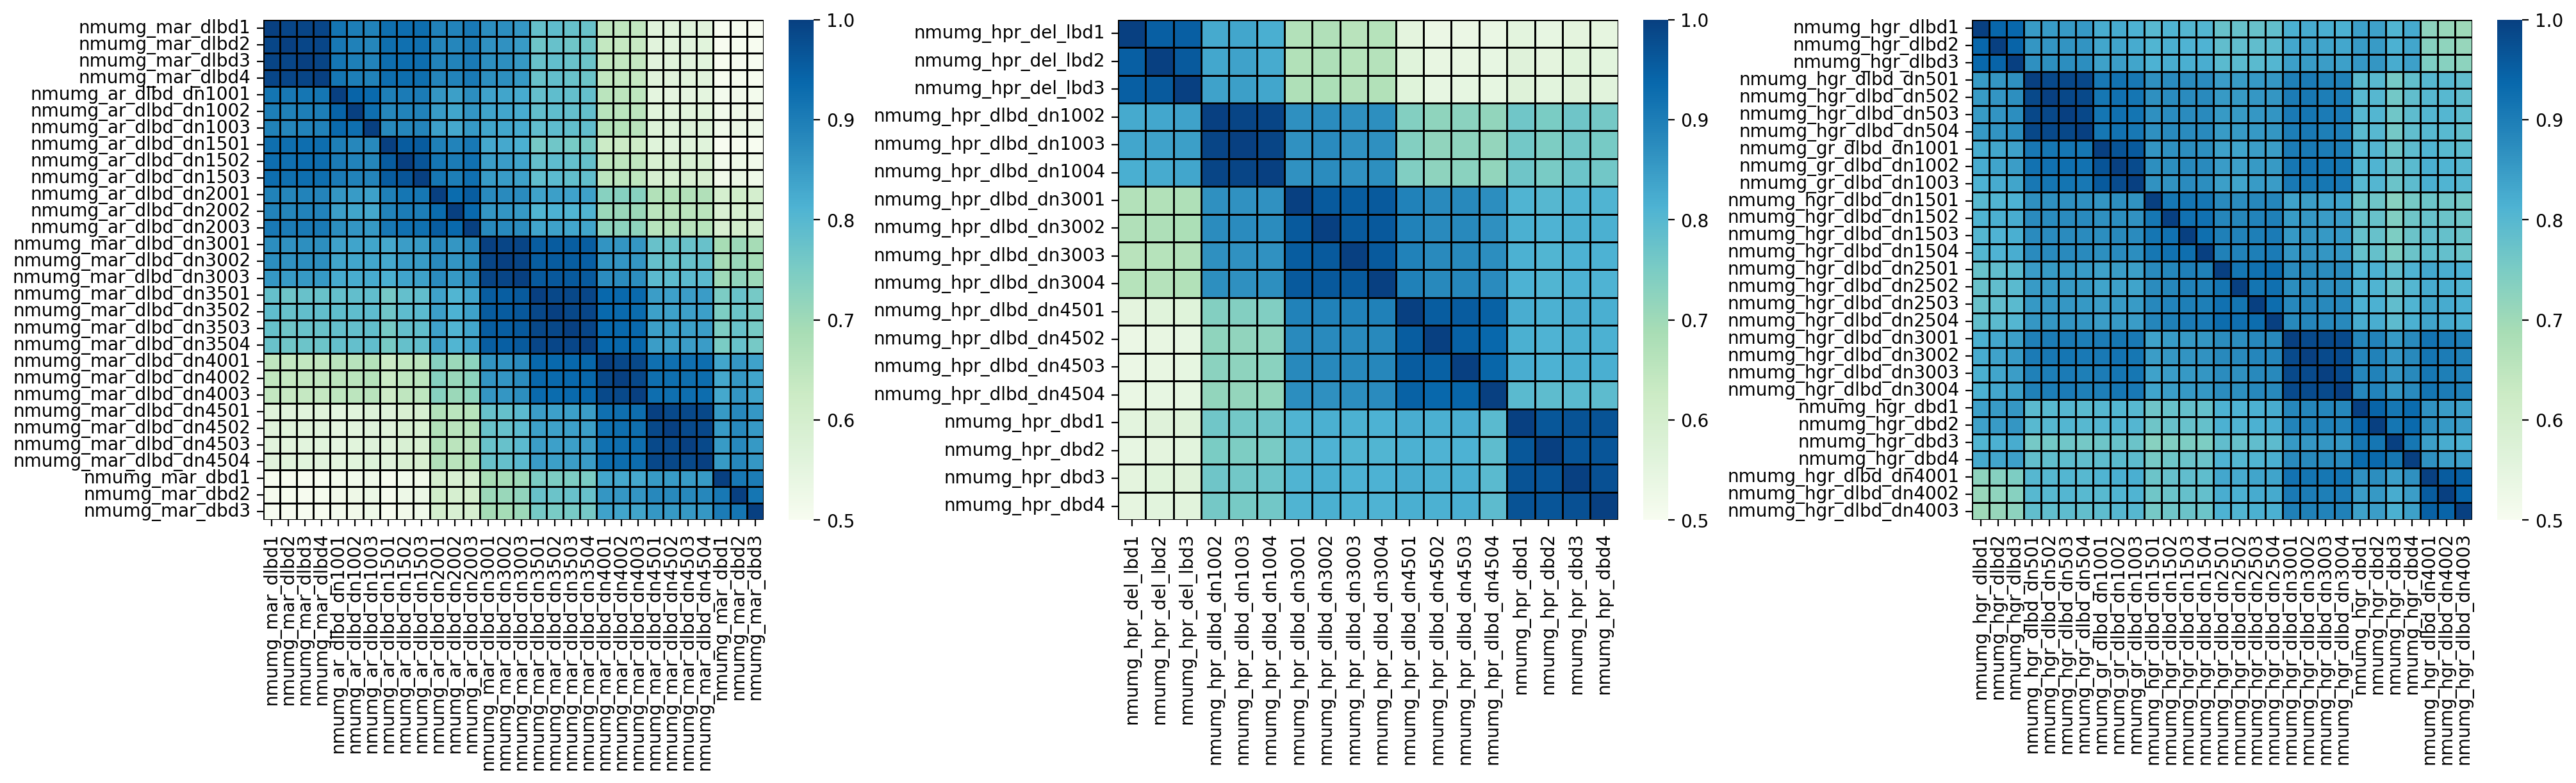

In [13]:
data1 = pd.read_parquet('cell_peaks_dbddlbdwtlig/nmumg_sumsig600bp_of_peaks_artruncations_repeats_all.parquet')
scols1 = ['nmumg_mar_dlbd','nmumg_ar_dlbd_dn100', 'nmumg_ar_dlbd_dn150', 'nmumg_ar_dlbd_dn200',
        'nmumg_mar_dlbd_dn300',
       'nmumg_mar_dlbd_dn350', 'nmumg_mar_dlbd_dn400', 'nmumg_mar_dlbd_dn450','nmumg_mar_dbd', ]
d1 = pd.DataFrame()
for i in scols1:
    d1 = pd.concat([d1, data1.filter(regex=i + '[1|2|3|4]')], axis=1)
    
data2 = pd.read_parquet('cell_peaks_dbddlbdwtlig/nmumg_sumsig600bp_of_peaks_prtruncations_repeats_all.parquet')
scols2 = ['nmumg_hpr_del_lbd', 'nmumg_hpr_dlbd_dn100',
       'nmumg_hpr_dlbd_dn300', 'nmumg_hpr_dlbd_dn450', 'nmumg_hpr_dbd', ]

d2 = pd.DataFrame()
for i in scols2:
    d2 = pd.concat([d2, data2.filter(regex=i + '[1|2|3|4]')], axis=1) 

data3 = pd.read_parquet('cell_peaks_dbddlbdwtlig/nmumg_sumsig600bp_of_peaks_grtruncations_repeats_all.parquet')
scols3 =  ['nmumg_hgr_dlbd', 'nmumg_hgr_dlbd_dn50','nmumg_gr_dlbd_dn100', 
       'nmumg_hgr_dlbd_dn150', 'nmumg_hgr_dlbd_dn250', 'nmumg_hgr_dlbd_dn300','nmumg_hgr_dbd',
       'nmumg_hgr_dlbd_dn400',]
d3 = pd.DataFrame()
for i in scols3:
    d3 = pd.concat([d3, data3.filter(regex=i + '[1|2|3|4]')], axis=1) 
fig, ax = plt.subplots(1,3, figsize=(20,6), constrained_layout=True)
sns.heatmap(d1.corr(), cmap='GnBu', ax=ax[0], linecolor='k', lw=.5, vmin=.5, annot=False, xticklabels=d1.columns, yticklabels=d1.columns)
sns.heatmap(d2.drop('nmumg_hpr_dlbd_dn1001', axis=1).corr(), cmap='GnBu', ax=ax[1], linecolor='k', lw=1, vmin=.5, annot=False, xticklabels=d2.drop('nmumg_hpr_dlbd_dn1001', axis=1).columns, yticklabels=d2.drop('nmumg_hpr_dlbd_dn1001', axis=1).columns)
sns.heatmap(d3.corr(), cmap='GnBu', ax=ax[2], linecolor='k', lw=.5, vmin=.5, annot=False, xticklabels=d3.columns, yticklabels=d3.columns)
fig.savefig('figures/Fig4/trunc_corr.pdf')

In [14]:
t = nmeta.filter(regex='ar', axis=0).filter(regex='dbd|lbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'AverageBw'].to_dict()

for key, value in t.items():
    a = pw.open(value)
    sl = []
    for c,l in a.chroms().items():
        sl.append(a.stats(c,1,l, 'max')[0])

    print(key, np.median(sl))
    a.close()

nmumg_ar_dlbd_dn100 5.896939992904663
nmumg_ar_dlbd_dn150 9.20615005493164
nmumg_ar_dlbd_dn200 5.623785018920898
nmumg_mar_dbd 9.236394882202148
nmumg_mar_dlbd 13.711750030517578
nmumg_mar_dlbd_dn300 16.007500171661377
nmumg_mar_dlbd_dn350 12.172200202941895
nmumg_mar_dlbd_dn400 10.39079999923706
nmumg_mar_dlbd_dn450 12.648600101470947


In [15]:
def get_targets_df(data, thresh, t_name,):

    threshed = data>=thresh
    targets = pd.DataFrame(np.where(threshed.values)[0],
    np.where(threshed.values)[1]).reset_index().groupby('index').agg({0:lambda x: list(x)})
    targets.index = data.columns

    numeric_to_name = lambda x: data.iloc[targets.iloc[x].values[0]].sort_values(ascending=False, by=data.columns.values[x]).index.values

    targets.loc[:, t_name] = list(map(numeric_to_name, range(targets.index.shape[0])))
    targets = targets.drop(0, axis=1)
    return targets


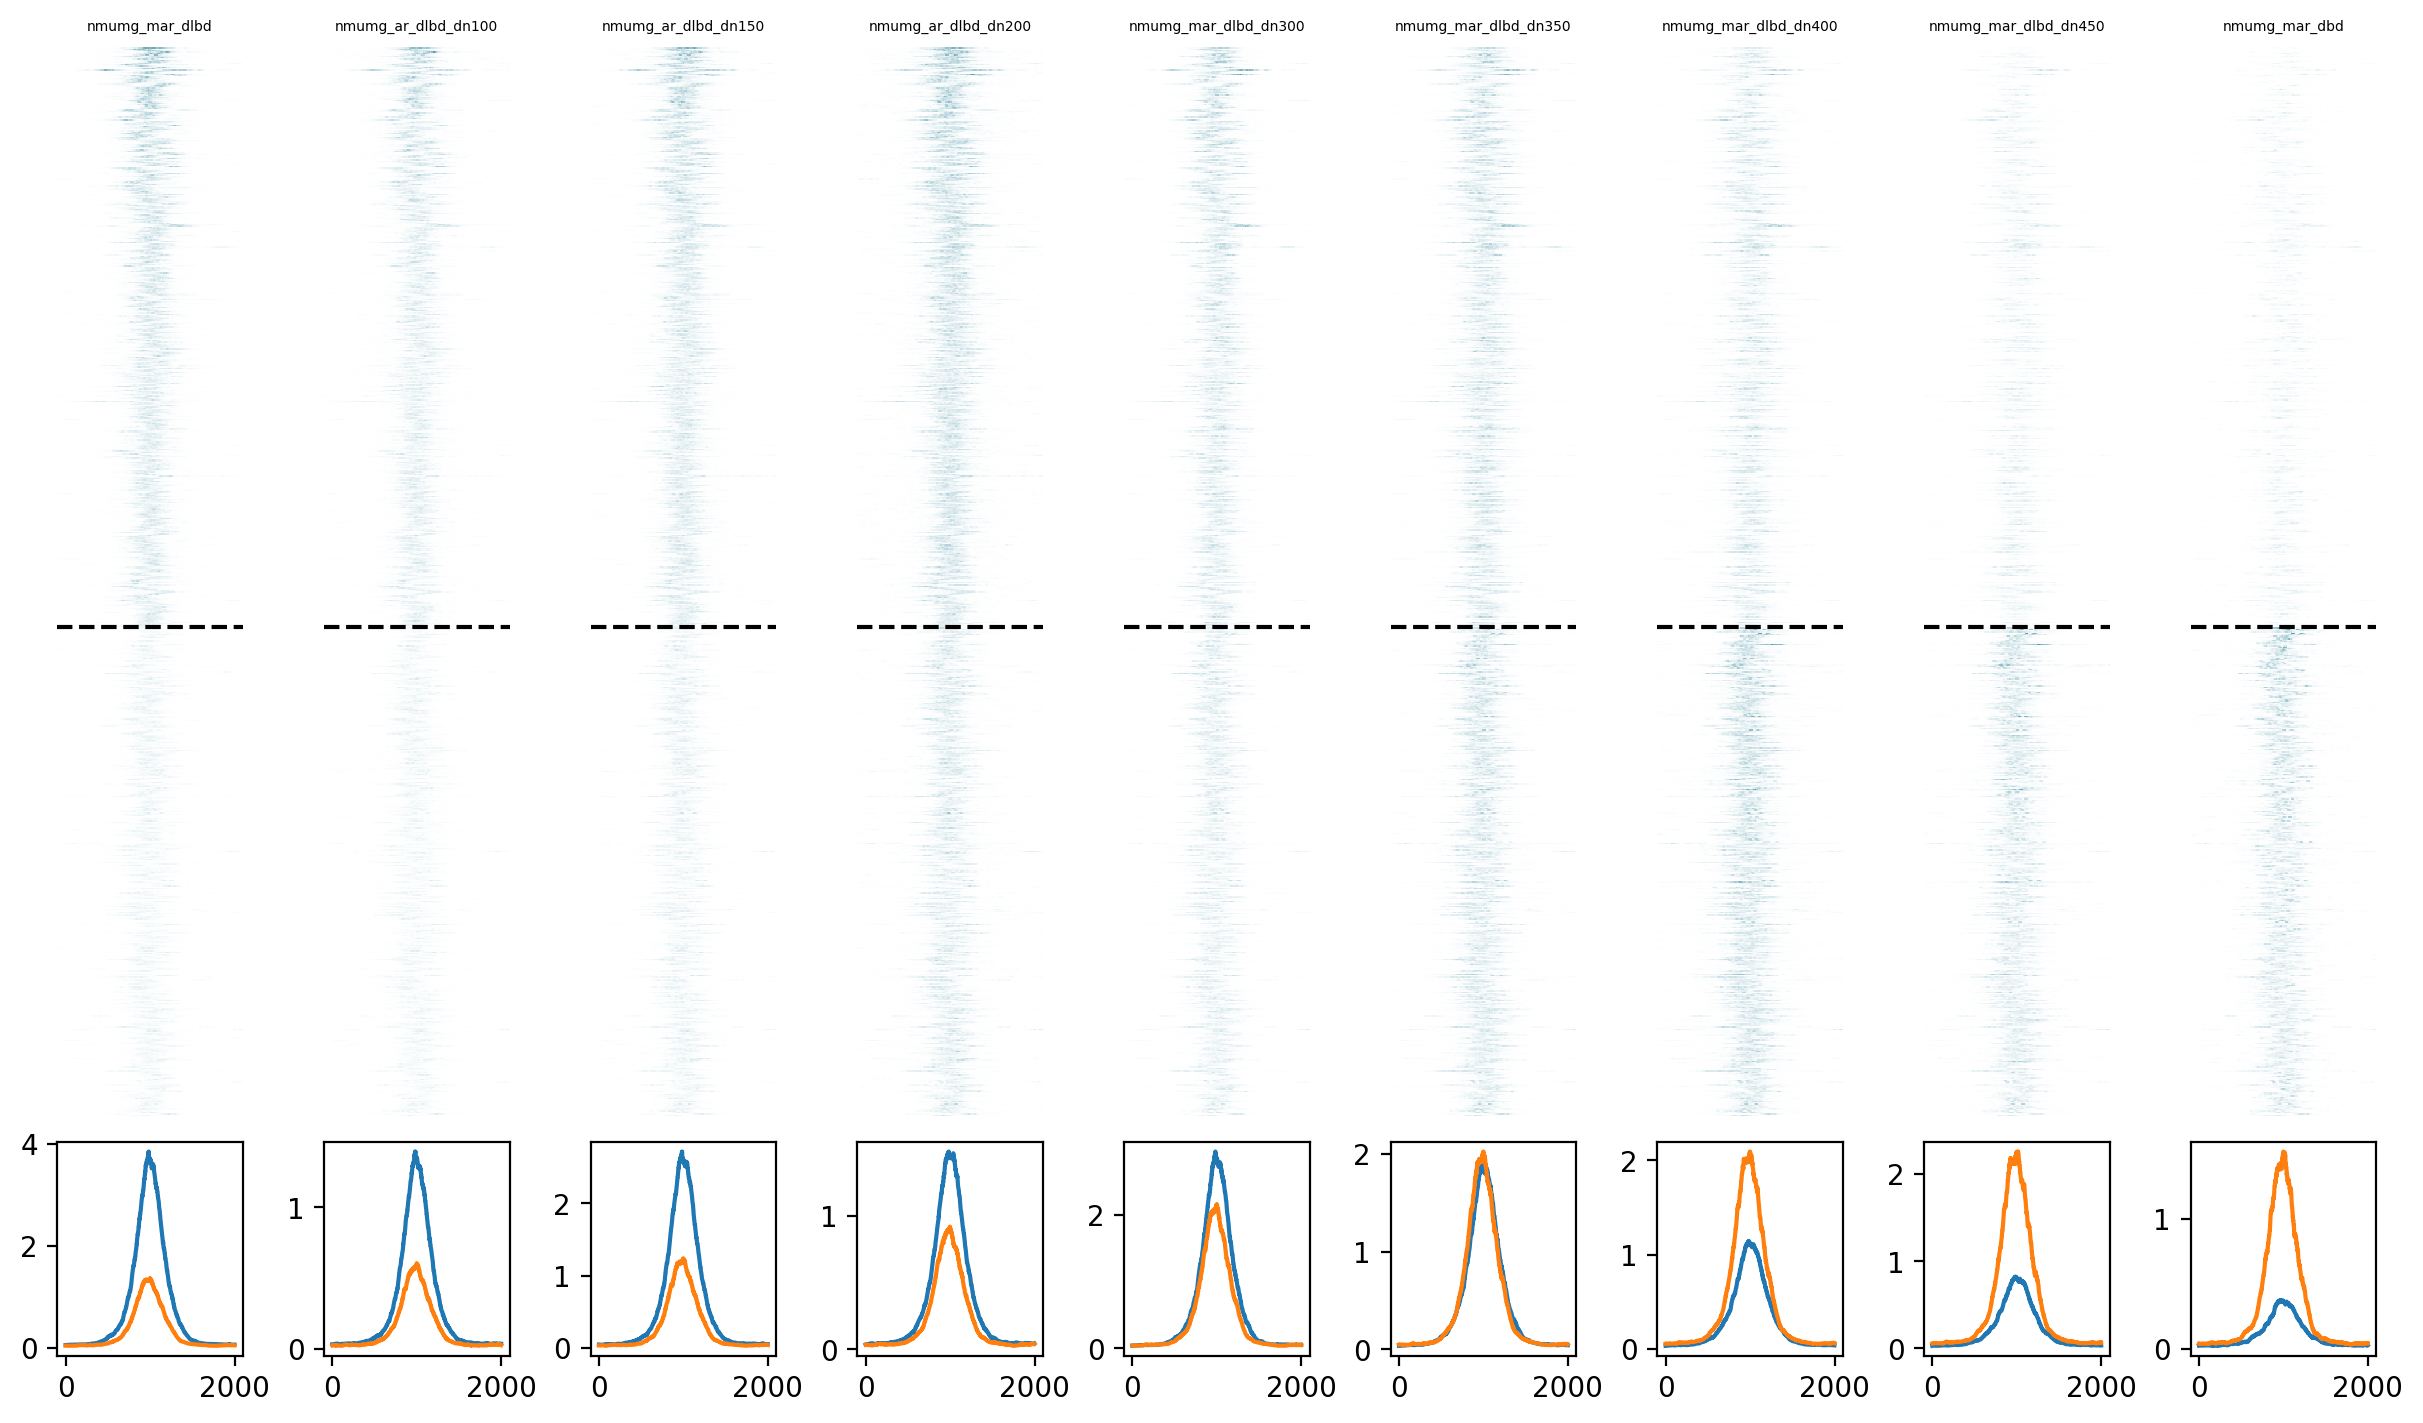

In [16]:
data1 = pd.read_parquet('cell_peaks_dbddlbdwtlig/nmumg_ar_trunc_clustered_peak_wsignals.parquet')
z = data1.set_index('nindex').loc[:, scols1]
z = (z-z.mean()) / z.std()
ind = pd.Index(np.concatenate(np.concatenate(get_targets_df(z,3,'a').values))).drop_duplicates()

sigs = ['cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_nmumg_mar_dlbd.parquet',
    'cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_nmumg_ar_dlbd_dn100.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_nmumg_ar_dlbd_dn150.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_nmumg_ar_dlbd_dn200.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_nmumg_mar_dlbd_dn300.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_nmumg_mar_dlbd_dn350.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_nmumg_mar_dlbd_dn400.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_nmumg_mar_dlbd_dn450.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_artruncations_nmumg_mar_dbd.parquet',
]

dl_ind = list(z.query("nmumg_mar_dlbd>3 & nmumg_mar_dbd<2").sort_values(by='nmumg_mar_dlbd', ascending=False).index)
dbd_ind = list(z.query("nmumg_mar_dlbd<2 & nmumg_mar_dbd>=3").sort_values(by='nmumg_mar_dbd', ascending=False).index)
ind =  dl_ind+dbd_ind
     

fig, ax = plt.subplots(2,9, figsize=(12,7), constrained_layout=True, height_ratios=[5,1])
ax=ax.T

sigs_d = dict()

for (axi, axk),sig in zip(ax,sigs):
    sigi = pd.read_parquet(sig)
    name = sig.split('/')[-1].split('artruncations_')[-1].split('.')[0]
    sns.heatmap(sigi.loc[ind], ax=axi,  cmap=sns.blend_palette(['white', '#056a85'], as_cmap=True),
                vmax=sigi.loc[ind].max().max()*1.4, cbar=False, xticklabels=False, yticklabels=False, rasterized=True)
    axi.axhline(len(dl_ind), c='k', ls='--')
    axi.set_ylabel('')
    name = sig.split('/')[-1].split('.')[0].split('ations_')[1]
    axi.set_title(name, size=5)
    
    dlbdm = sigi.loc[dl_ind].mean()
    dbdm = sigi.loc[dbd_ind].mean()
    sigs_d[name] = {'dlbd':dlbdm, 'dbd':dbdm}
    
    axk.plot(dlbdm)
    axk.plot(dbdm)
fig.savefig('figures/Fig4/trunc_signals_htmp_ar.pdf')


/tmp/ipykernel_2655030/3435485463.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summits = pd.DataFrame(sigs_d).applymap(lambda x: np.max(x))
/tmp/ipykernel_2655030/3435485463.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


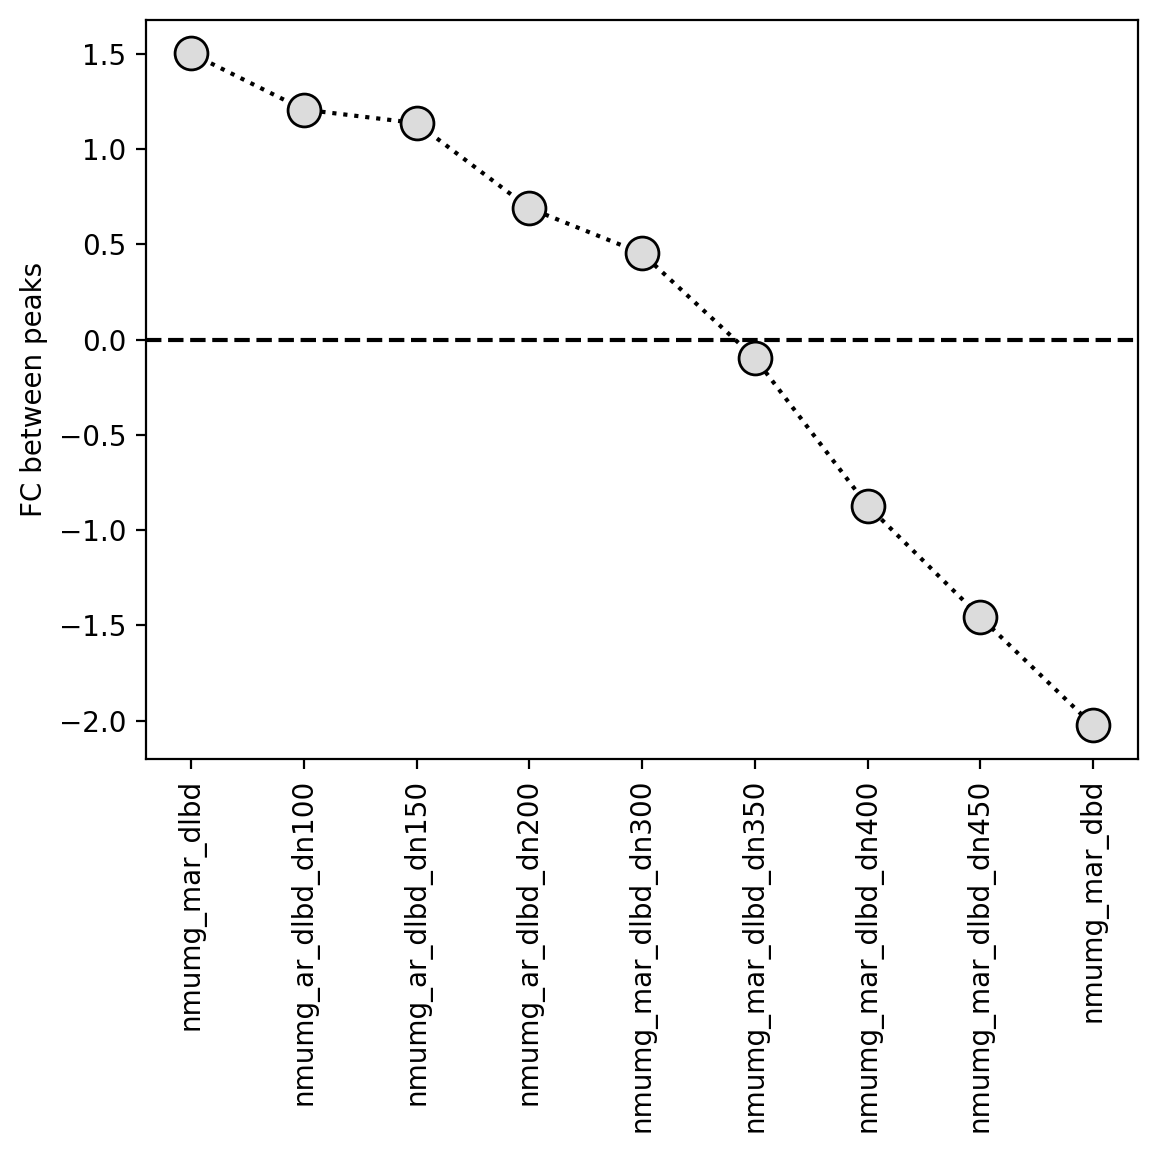

In [17]:
summits = pd.DataFrame(sigs_d).applymap(lambda x: np.max(x))
mpeak_fc = (summits.iloc[0,:] / summits.iloc[1,:])

fig, ax = plt.subplots(1)

ax.scatter(mpeak_fc.index, np.log2(mpeak_fc), s=140, ec='k', c='gainsboro', zorder=20)
ax.plot(mpeak_fc.index, np.log2(mpeak_fc), c='k', ls=':')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(0, c='k', ls='--')
ax.set_ylabel('FC between peaks')

fig.savefig('figures/Fig4/trunc_signals_peaklog2fc_ar.pdf')


In [18]:

# mot_signals = sorted(glob.glob('cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_*_signals_on_motifs.parquet'))


# mot_signals = ['cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_signals_on_motifs.parquet',
#     'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_ar_dlbd_dn100_signals_on_motifs.parquet',
#  'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_ar_dlbd_dn150_signals_on_motifs.parquet',
#  'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_ar_dlbd_dn200_signals_on_motifs.parquet',
#  'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_dn300_signals_on_motifs.parquet',
#  'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_dn350_signals_on_motifs.parquet',
#  'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_dn400_signals_on_motifs.parquet',
#  'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_dn450_signals_on_motifs.parquet',
#   'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dbd_signals_on_motifs.parquet',

#  ]

# alldf = pd.DataFrame()

# for sig in mot_signals:
#     a = pd.read_parquet(sig)
#     analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))].groupby('id', group_keys=False)\
#     .apply(filter_top_quantile, 0.9).groupby('id').mean().T
#     analyzed.columns = [x+ sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '')\
#                         for x in analyzed.columns]
#     alldf = pd.concat([alldf, analyzed], axis=1)

# fig = plt.figure(figsize=(33,8), constrained_layout=True, dpi=200)    

# subf = fig.subfigures(1,4, width_ratios=[10,2,5,5])


# ax = subf[0].subplots(4,9, sharex=False)

# ax= ax

# lens_big_dict = dict()
# enrich_big_dict = dict()

# for i, axrow,c in zip(['NR','halfsite', 'FOX', 'AP1'], ax, ['purple', '#56e15e', 'salmon', '#cee156']):
#         name = alldf.filter(regex=i).columns
        
#         for namei, axcol in zip(name, axrow):
#             ad = alldf.loc[:, namei]
#             enrich_big_dict[namei] = np.log2((ad.iloc[list(np.arange(70,90)) + list(np.arange(110,130))].sum() /\
#     ad.iloc[list(np.arange(0,20)) + list(np.arange(180,200))].sum()))
#             rfunc = lambda x: find_gap_length(x.iloc[np.arange(75,125)], x.iloc[np.arange(75,125)].median())
#             lendict = {namei:rfunc(ad)}
#             lens_big_dict[namei] = lendict
#             axcol.plot(ad,  label=namei, c=c)
#             axcol.set_xticks('')
#             axcol.set_title(namei.split('_signals_on')[0].split('trunc_')[1])
            
# for i in np.arange(len(mot_signals)):
#     ax[1][i].sharey(ax[0][i])
#     ax[2][i].sharey(ax[0][i])
#     ax[3][i].sharey(ax[0][i])
# ax[0][0].set_ylabel("NR")
# ax[1][0].set_ylabel("NR halfsite")
# ax[2][0].set_ylabel("FOX")
# ax[3][0].set_ylabel("AP1")



# len_df = pd.DataFrame(pd.DataFrame(lens_big_dict).mean(axis=1))

# len_df.loc[:,'motif'] = [x[0] for x in len_df.index.str.split('_trunc_')]
# len_df.loc[:, 'tf'] = [x[1] for x in len_df.index.str.split('_trunc_')]
# len_df = len_df.pivot(columns='motif', index='tf', values=0)

# ind = ['mar_dlbd_signals_on_motifs.parquet',
#     'ar_dlbd_dn100_signals_on_motifs.parquet',
#        'ar_dlbd_dn150_signals_on_motifs.parquet',
#        'ar_dlbd_dn200_signals_on_motifs.parquet',
#        'mar_dlbd_dn300_signals_on_motifs.parquet',
#        'mar_dlbd_dn350_signals_on_motifs.parquet',
#        'mar_dlbd_dn400_signals_on_motifs.parquet',
#        'mar_dlbd_dn450_signals_on_motifs.parquet',
#         'mar_dbd_signals_on_motifs.parquet',
#        ]
# len_df = len_df.loc[ind, :]


# enrich_df = pd.DataFrame(enrich_big_dict, index=['enrich']).T
# enrich_df.loc[:,'motif'] = [x[0] for x in enrich_df.index.str.split('_trunc_')]
# enrich_df.loc[:, 'tf'] = [x[1] for x in enrich_df.index.str.split('_trunc_')]
# enrich_df = enrich_df.pivot(columns='motif', index='tf', values='enrich')

# ind = ['mar_dlbd_signals_on_motifs.parquet',
#     'ar_dlbd_dn100_signals_on_motifs.parquet',
#        'ar_dlbd_dn150_signals_on_motifs.parquet',
#        'ar_dlbd_dn200_signals_on_motifs.parquet',
#        'mar_dlbd_dn300_signals_on_motifs.parquet',
#        'mar_dlbd_dn350_signals_on_motifs.parquet',
#        'mar_dlbd_dn400_signals_on_motifs.parquet',
#        'mar_dlbd_dn450_signals_on_motifs.parquet',
#         'mar_dbd_signals_on_motifs.parquet',
#        ]
# enrich_df = enrich_df.loc[ind, :]

# ax= subf[1].subplots(1, )
# sns.heatmap(enrich_df, cmap='GnBu',
#             linewidth=1, linecolor='k', annot=len_df.values, vmin=1, vmax=2, ax=ax)

# ax.set_yticklabels('')

# axfoot, corrax = subf[2].subplots(2,1, sharex=True, )
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_NRar'], label='NR', c=enrich_df.loc[:, 'GR_NRar'], cmap='Purples', vmin=1, vmax=2, ec='k', s=120)
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_AP1ar'], label='AP1', c=enrich_df.loc[:, 'GR_AP1ar'], cmap='Blues', vmin=1, vmax=2, ec='k', s=120)
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_FOXar'], label='FOX', c=enrich_df.loc[:, 'GR_FOXar'], cmap='Reds', vmin=1, vmax=2, ec='k', s=120)
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_halfsitear'], label='halfsite', c=enrich_df.loc[:, 'GR_halfsitear'], cmap='Greens', vmin=1, vmax=2, ec='k', s=120)


# axfoot.plot(len_df.index, len_df.loc[:, 'GR_NRar'], c='gray', ls='--', lw=.5)
# axfoot.plot(len_df.index, len_df.loc[:, 'GR_AP1ar'], c='gray', ls='--', lw=.5)
# axfoot.plot(len_df.index, len_df.loc[:, 'GR_FOXar'], c='gray', ls='--', lw=.5)
# axfoot.plot(len_df.drop('ar_dlbd_dn100_signals_on_motifs.parquet').index, len_df.drop('ar_dlbd_dn100_signals_on_motifs.parquet').loc[:, 'GR_halfsitear'], c='gray', ls='--', lw=.5)

# axfoot.legend()
# axfoot.set_xticks(np.arange(9), ['nmumg_mar_dlbd', 'nmumg_ar_dlbd_dn100', 'nmumg_ar_dlbd_dn150',
#        'nmumg_ar_dlbd_dn200', 'nmumg_mar_dlbd_dn300', 'nmumg_mar_dlbd_dn350',
#        'nmumg_mar_dlbd_dn400', 'nmumg_mar_dlbd_dn450', 'nmumg_mar_dbd'], rotation=90)
    

# mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_ar_trunc_cluster', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_ar_trunc_cluster',
# 'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_ar_trunc_cluster', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_ar_trunc_cluster', ]
# mots_enrich = pd.concat([load_and_rename_mot(x, x.split('/')[-1]) for x in mot_folders], axis=1)
# clustered_w_motifs = pd.concat([data1.set_index('nindex'), mots_enrich.fillna(0)], axis=1).fillna(0)
# ax = subf[3].subplots(1)
# corr = clustered_w_motifs.query("NR_nmumg_ar_trunc_cluster>0").loc[:, mpeak_fc.index].corr()
# sns.heatmap(corr,
#             cmap='GnBu', ax=ax)
# corrax.scatter(len_df.index, corr.nmumg_mar_dlbd,c='salmon', s=120)
# corrax.scatter(len_df.index, corr.nmumg_mar_dbd,c='darkslateblue', s=120)

# corrax.plot(len_df.index, corr.nmumg_mar_dlbd, c='gray', ls='--')
# corrax.plot(len_df.index, corr.nmumg_mar_dbd, c='gray', ls='--')

# corrax.set_xticks(np.arange(9), ['nmumg_mar_dlbd', 'nmumg_ar_dlbd_dn100', 'nmumg_ar_dlbd_dn150',
#        'nmumg_ar_dlbd_dn200', 'nmumg_mar_dlbd_dn300', 'nmumg_mar_dlbd_dn350',
#        'nmumg_mar_dlbd_dn400', 'nmumg_mar_dlbd_dn450', 'nmumg_mar_dbd'], rotation=90)
#     # fig.savefig('figures/footshape.pdf')

In [19]:
mot_signals = ['cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_signals_on_motifs.parquet',
    'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_ar_dlbd_dn100_signals_on_motifs.parquet',
 'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_ar_dlbd_dn150_signals_on_motifs.parquet',
 'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_ar_dlbd_dn200_signals_on_motifs.parquet',
 'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_dn300_signals_on_motifs.parquet',
 'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_dn350_signals_on_motifs.parquet',
 'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_dn400_signals_on_motifs.parquet',
 'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dlbd_dn450_signals_on_motifs.parquet',
  'cell_peaks_dbddlbdwtlig/ar_trunc_nmumg_mar_dbd_signals_on_motifs.parquet',

 ]
alldf = pd.DataFrame()
allfoot_df = pd.DataFrame()
for sig in mot_signals:
    a = pd.read_parquet(sig)
    analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))]
    foot_df = pd.DataFrame()
    for idi in analyzed.id.unique():
        proc_df = filter_top_quantile(analyzed[analyzed.id == idi].loc[:, np.arange(200).astype(str)], 0.9)
        top5_cols = (
                proc_df.iloc[:, :200]
                .mean()
                .sort_values(ascending=False)
                .iloc[:5]
                .index
                .astype(int)
            )
        null = proc_df.iloc[:, top5_cols].values.flatten()
        func = lambda x: stats.mannwhitneyu(null, x)[1]
        calc_pvs = proc_df.iloc[:, :200].apply(func, axis=0)
        calc_pvs[(calc_pvs == 0)] = calc_pvs[~(calc_pvs == 0)].min()
        m10log10pval = (-10 * np.log10(calc_pvs))
        
        foot  = pd.DataFrame(compute_footprint_lengths(m10log10pval.index.astype(int), m10log10pval, np.arange(0.05,1.05,0.05)), index=[idi]).T
        foot_df = pd.concat([foot_df, foot], axis=1)
    analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
    analyzed.columns = [x+ '_' + sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '') for x in analyzed.columns]
    foot_df.columns = [x+ '_' + sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '') for x in foot_df.columns]

    alldf = pd.concat([alldf, analyzed], axis=1)
    allfoot_df = pd.concat([allfoot_df, foot_df], axis=1)

/tmp/ipykernel_2655030/231687708.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_2655030/231687708.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_2655030/2

In [20]:
labels = ['nmumg_mar_dlbd', 'nmumg_ar_dlbd_dn100', 'nmumg_ar_dlbd_dn150',
       'nmumg_ar_dlbd_dn200', 'nmumg_mar_dlbd_dn300', 'nmumg_mar_dlbd_dn350',
       'nmumg_mar_dlbd_dn400', 'nmumg_mar_dlbd_dn450', 'nmumg_mar_dbd']

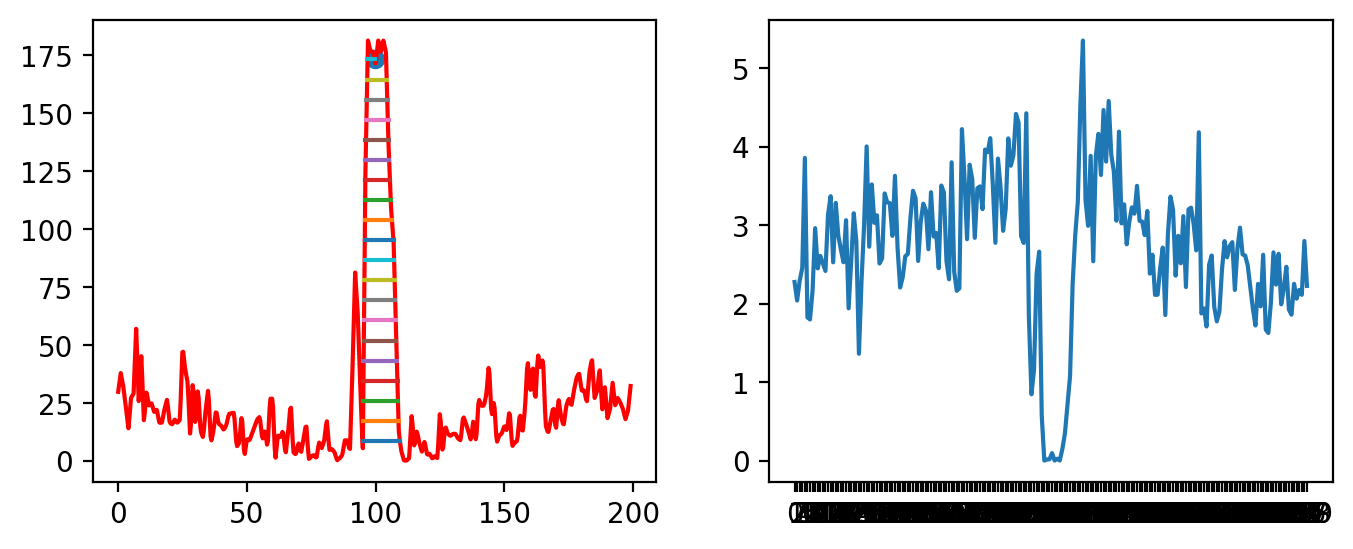

In [21]:
x = m10log10pval.index.astype(int)
y = m10log10pval
interp_func = interp1d(x, y, kind='linear')

# Generate more dense x values for interpolation
window = 600
x_dense = np.linspace(min(x), max(x), window)
y_dense = interp_func(x_dense)  # Interpolated y values

# Find Peak
peak_index = int(window/2)
peak_x = x_dense[peak_index]
peak_y = y_dense[peak_index]

footprint_lengths = {}
thresholds = np.arange(0.05,1.05,0.05)

fig, (ax,ax1) = plt.subplots(1,2, figsize=(8,3))
ax.plot(x_dense, y_dense, c='r')
ax1.plot(proc_df.mean())

ax.scatter(peak_x, peak_y)


for threshold in thresholds:
    threshold_value = threshold * peak_y  # Compute threshold level

    # Find left and right drop-off points safely
    left_indices = np.where(y_dense[:peak_index] <= threshold_value)[0]
    right_indices = np.where(y_dense[peak_index:] <= threshold_value)[0]

    left_x = x_dense[left_indices[-1]] if len(left_indices) > 0 else None
    right_x = x_dense[right_indices[0] + peak_index] if len(right_indices) > 0 else None
    # Compute footprint length if both sides exist
    footprint_length = right_x - left_x if left_x is not None and right_x is not None else None
    ax.plot([left_x, right_x], np.ones(2)*threshold_value)

    footprint_lengths[threshold] = footprint_length

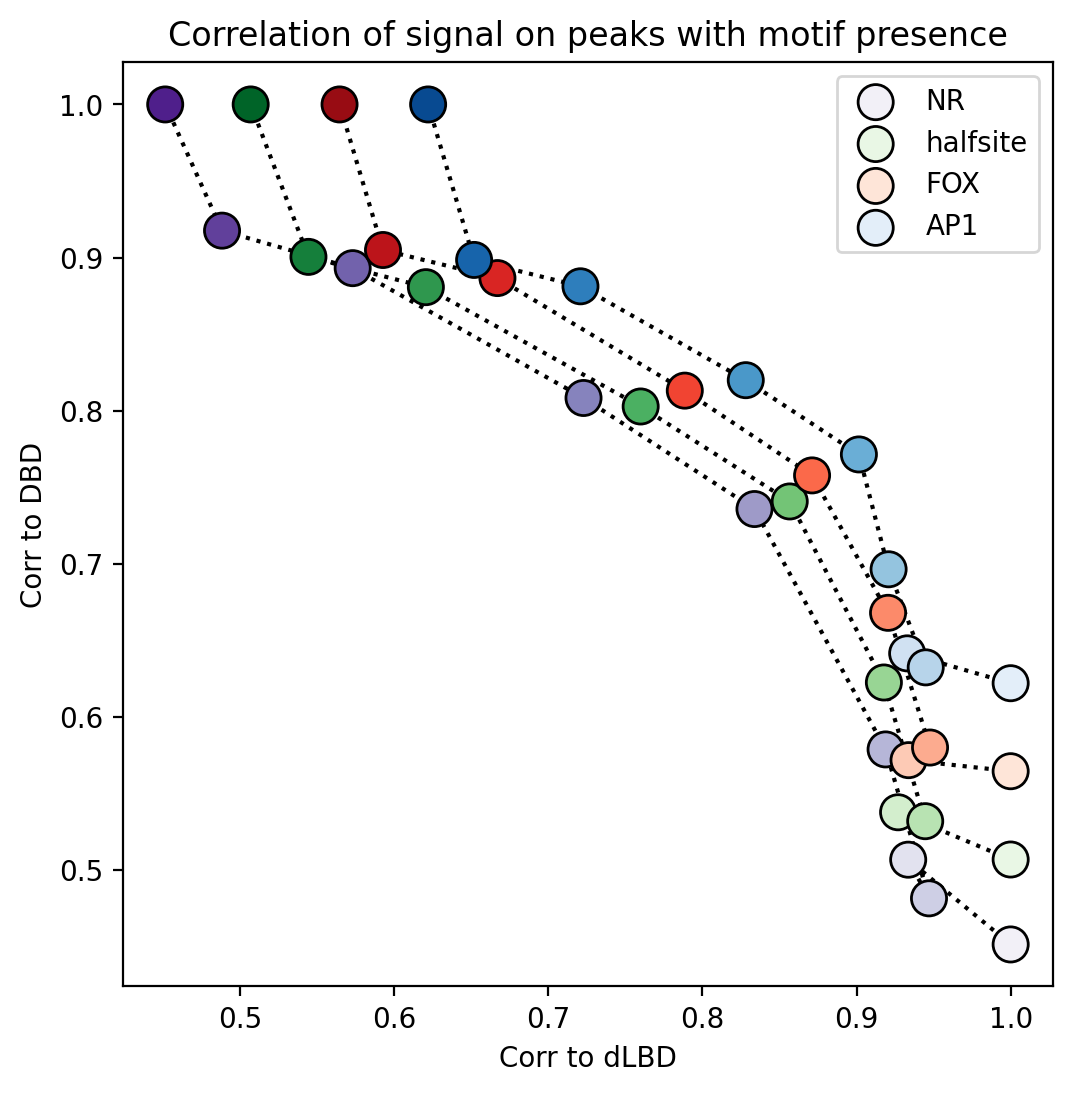

In [22]:
mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_ar_trunc_cluster', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_ar_trunc_cluster',
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_ar_trunc_cluster', 
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_ar_trunc_cluster', ]
mots_enrich = pd.concat([load_and_rename_mot(x, x.split('/')[-1]) for x in mot_folders], axis=1)
clustered_w_motifs = pd.concat([data1.set_index('nindex'), mots_enrich.fillna(0)], axis=1).fillna(0)

fig, ax = plt.subplots(1, figsize=(6,6))

ax.plot(clustered_w_motifs.query("NR_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("NR_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Purples', n_colors=len(labels)), s=160, ec='k', label='NR', zorder=20)


ax.plot(clustered_w_motifs.query("NR_hs_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_hs_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("NR_hs_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_hs_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Greens', n_colors=len(labels)), s=160, ec='k', label='halfsite', zorder=20)

ax.plot(clustered_w_motifs.query("FOX_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("FOX_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("FOX_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("FOX_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Reds', n_colors=len(labels)), s=160, ec='k', label='FOX', zorder=20)

ax.plot(clustered_w_motifs.query("AP1_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("AP1_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("AP1_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("AP1_nmumg_ar_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Blues', n_colors=len(labels)), s=160, ec='k', label='AP1', zorder=20)

ax.legend()
ax.set_xlabel('Corr to dLBD')
ax.set_ylabel('Corr to DBD')
ax.set_title('Correlation of signal on peaks with motif presence')
fig.savefig('figures/Fig5/signal_corr_w_motifs_ar.pdf')

/tmp/ipykernel_2655030/3348606901.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


Text(0.5, 1.05, 'Footprint size analyses')

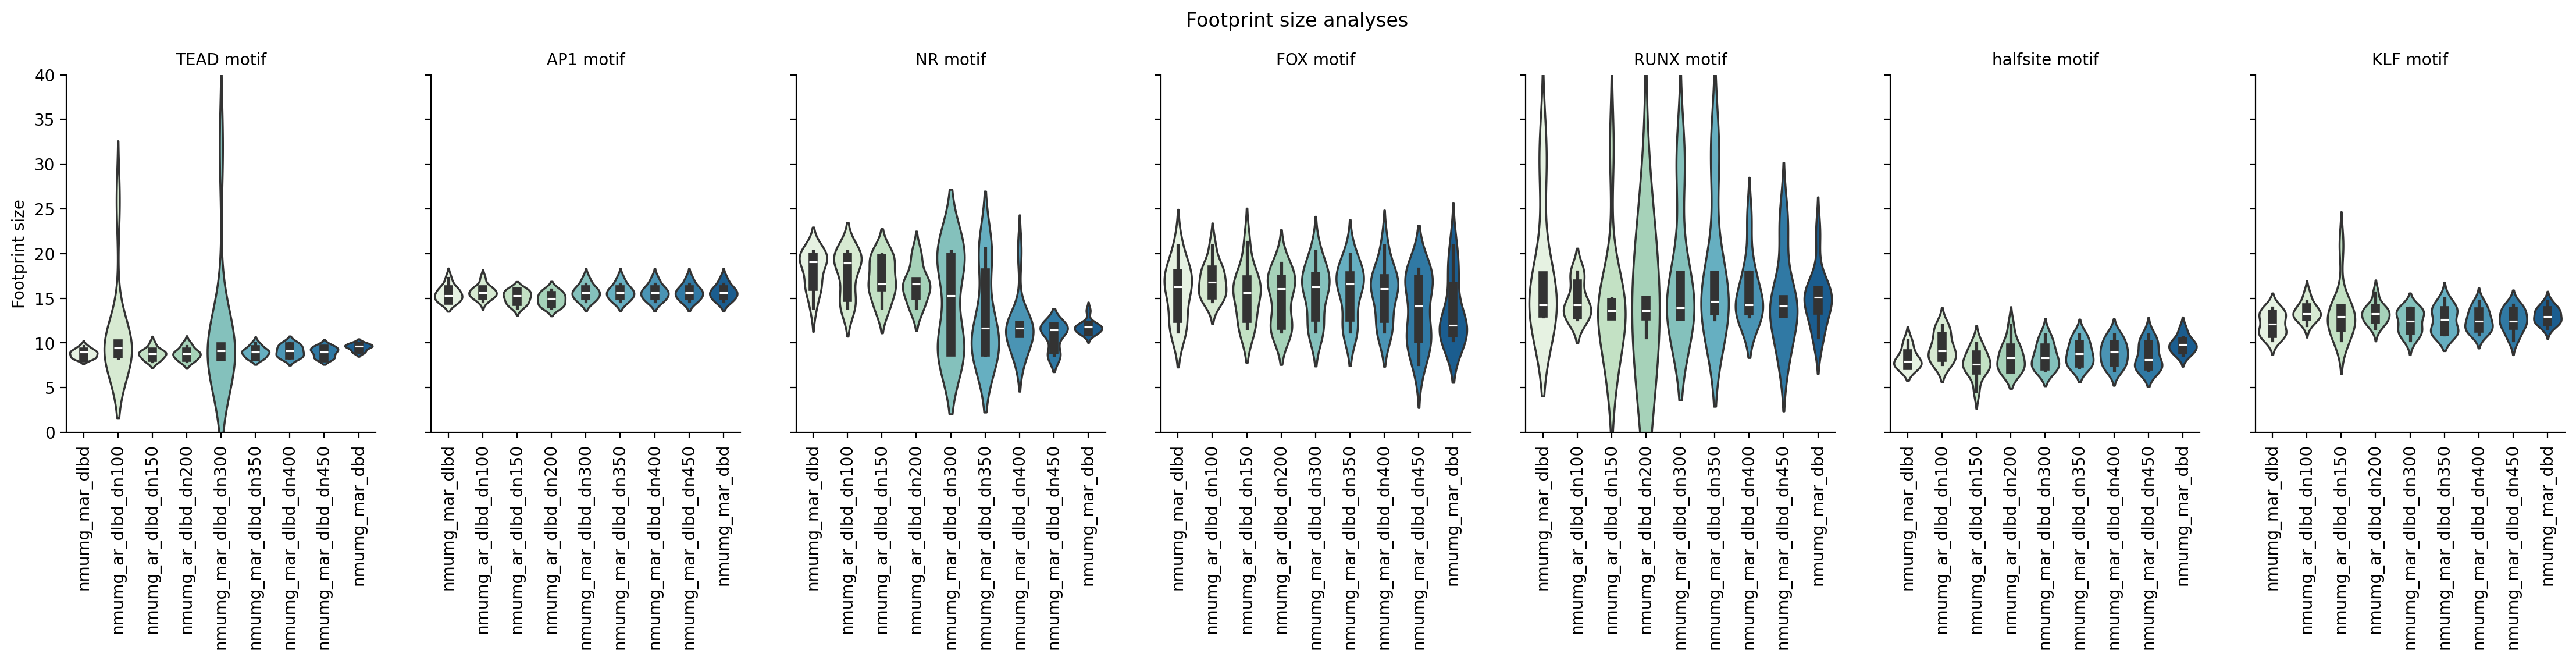

In [23]:
unstacked = allfoot_df.loc[0.3:0.75].unstack().reset_index()
unstacked = allfoot_df.iloc[:10,:].unstack().reset_index()

unstacked.loc[:, 'motif'] = unstacked.level_0.apply(lambda x: x.split('_')[1])
unstacked.loc[:, 'factor'] = unstacked.level_0.apply(lambda x: x.split('_sig')[0].split('trunc_')[1])
# unstacked.loc[:, 'type'] = unstacked.factor.apply(lambda x: '_'.join(x.split('_')[1:]))
unstacked = unstacked.drop('level_0', axis=1)
unstacked.replace('del_lbd', 'dlbd', inplace=True)

g = sns.catplot(
    unstacked, kind="violin",
    col="motif", y=0, x="factor",
    height=4, aspect=.8, sharey=True,native_scale=True, palette='GnBu'
)
g.set_axis_labels("", "Footprint size")
g.set_xticklabels(labels, rotation=90)
g.set(ylim=(0, 40))

g.set_titles("{col_name} {col_var}")
g.fig.suptitle("Footprint size analyses", y=1.05)  # Adjust y to control the vertical position
# g.figure.savefig('figures/Fig4/trunc_violins_ar.pdf')


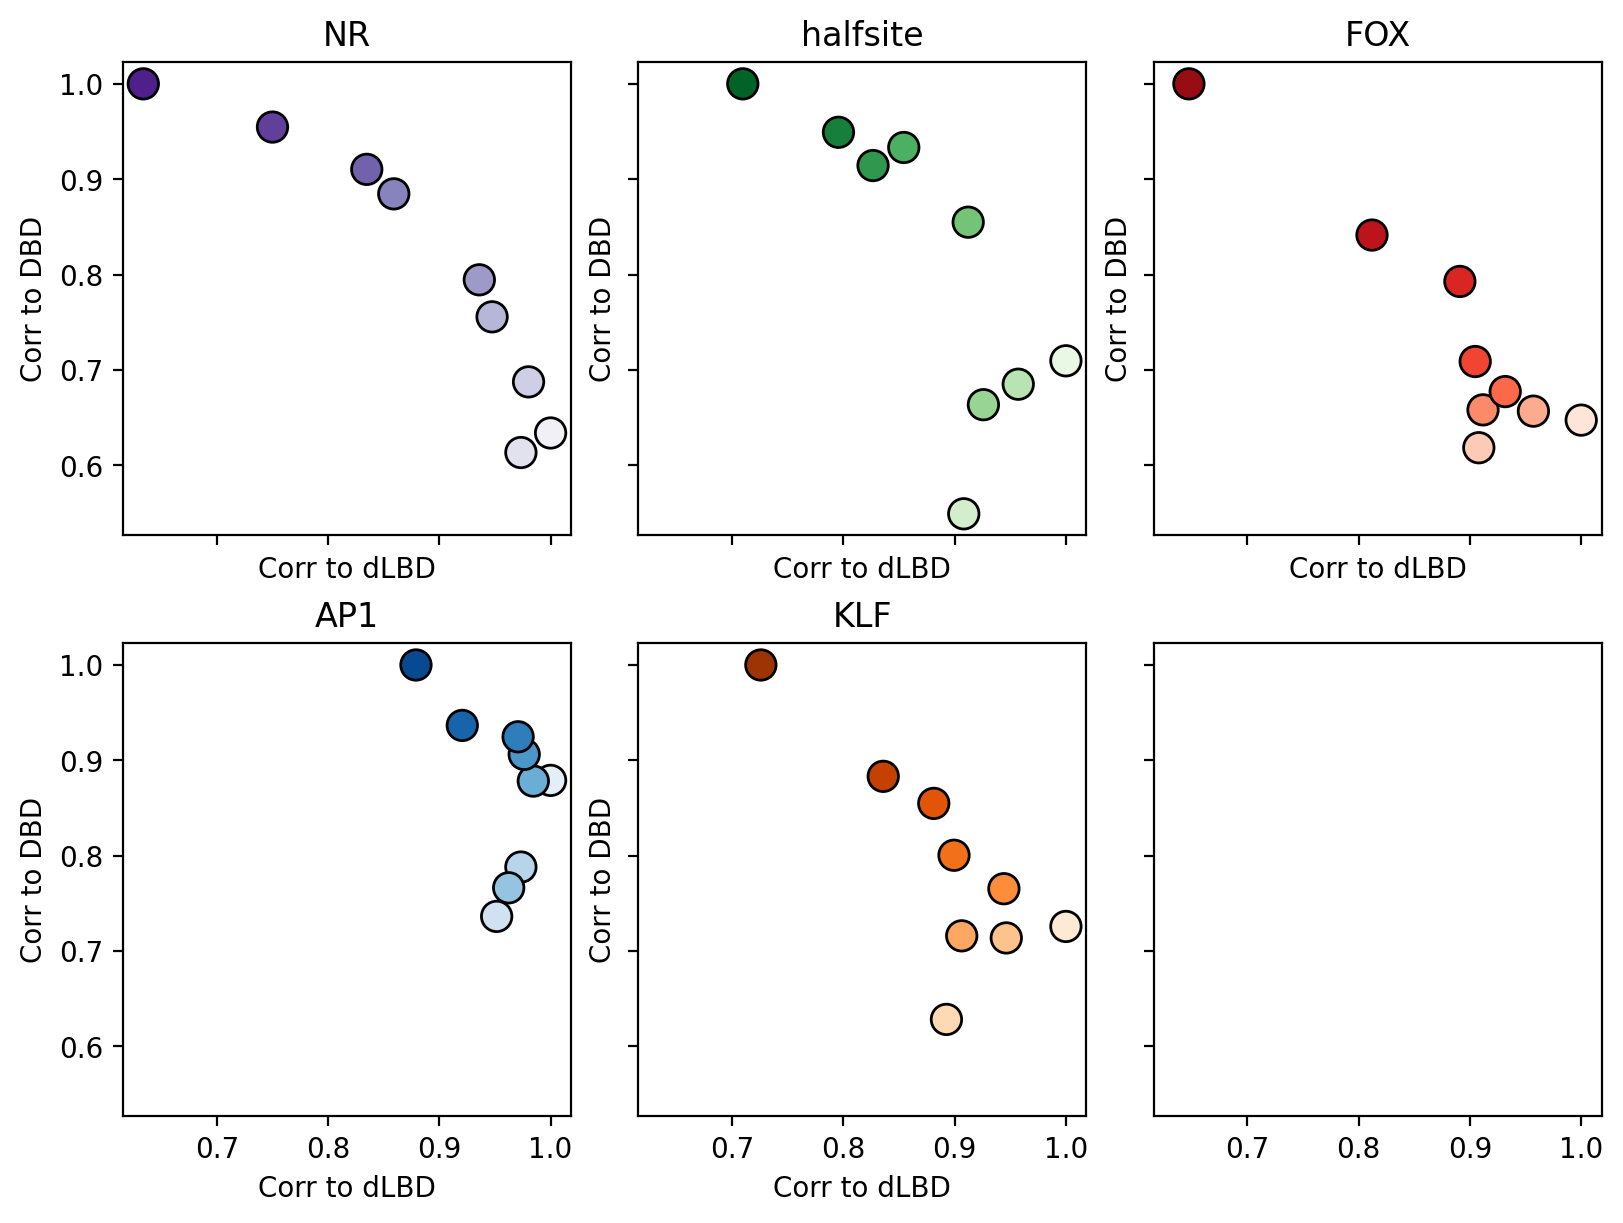

In [24]:
ids=['NR', 'halfsite', 'FOX', 'AP1', 'KLF']

cd = sns.color_palette('Purples', n_colors=len(labels))
all_corr = alldf.corr()

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, constrained_layout=True, figsize=(8,6))
ax= ax.flatten()
ax[0].scatter(alldf.filter(regex=ids[0]).corr().iloc[:, 0], alldf.filter(regex=ids[0]).corr().iloc[:, -1], c=sns.color_palette('Purples', n_colors=len(labels)), s=120, ec='k', label='NR')
ax[1].scatter(alldf.filter(regex=ids[1]).corr().iloc[:, 0], alldf.filter(regex=ids[1]).corr().iloc[:, -1], c=sns.color_palette('Greens', n_colors=len(labels)), s=120, ec='k', label='halfsite')
ax[2].scatter(alldf.filter(regex=ids[2]).corr().iloc[:, 0], alldf.filter(regex=ids[2]).corr().iloc[:, -1], c=sns.color_palette('Reds', n_colors=len(labels)), s=120, ec='k', label='FOX')
ax[3].scatter(alldf.filter(regex=ids[3]).corr().iloc[:, 0], alldf.filter(regex=ids[3]).corr().iloc[:, -1], c=sns.color_palette('Blues', n_colors=len(labels)), s=120, ec='k', label='AP1')
ax[4].scatter(alldf.filter(regex=ids[4]).corr().iloc[:, 0], alldf.filter(regex=ids[4]).corr().iloc[:, -1], c=sns.color_palette('Oranges', n_colors=len(labels)), s=120, ec='k', label='KLF')

for i, axi in zip(ids, ax):
    axi.set_title(i)
    axi.set_xlabel('Corr to dLBD')
    axi.set_ylabel('Corr to DBD')

# ax.legend()

fig.savefig('figures/Fig4/trunc_shape_corr_ar.pdf')


In [25]:
colormap = sns.blend_palette(['white', 'slateblue'], as_cmap=True)


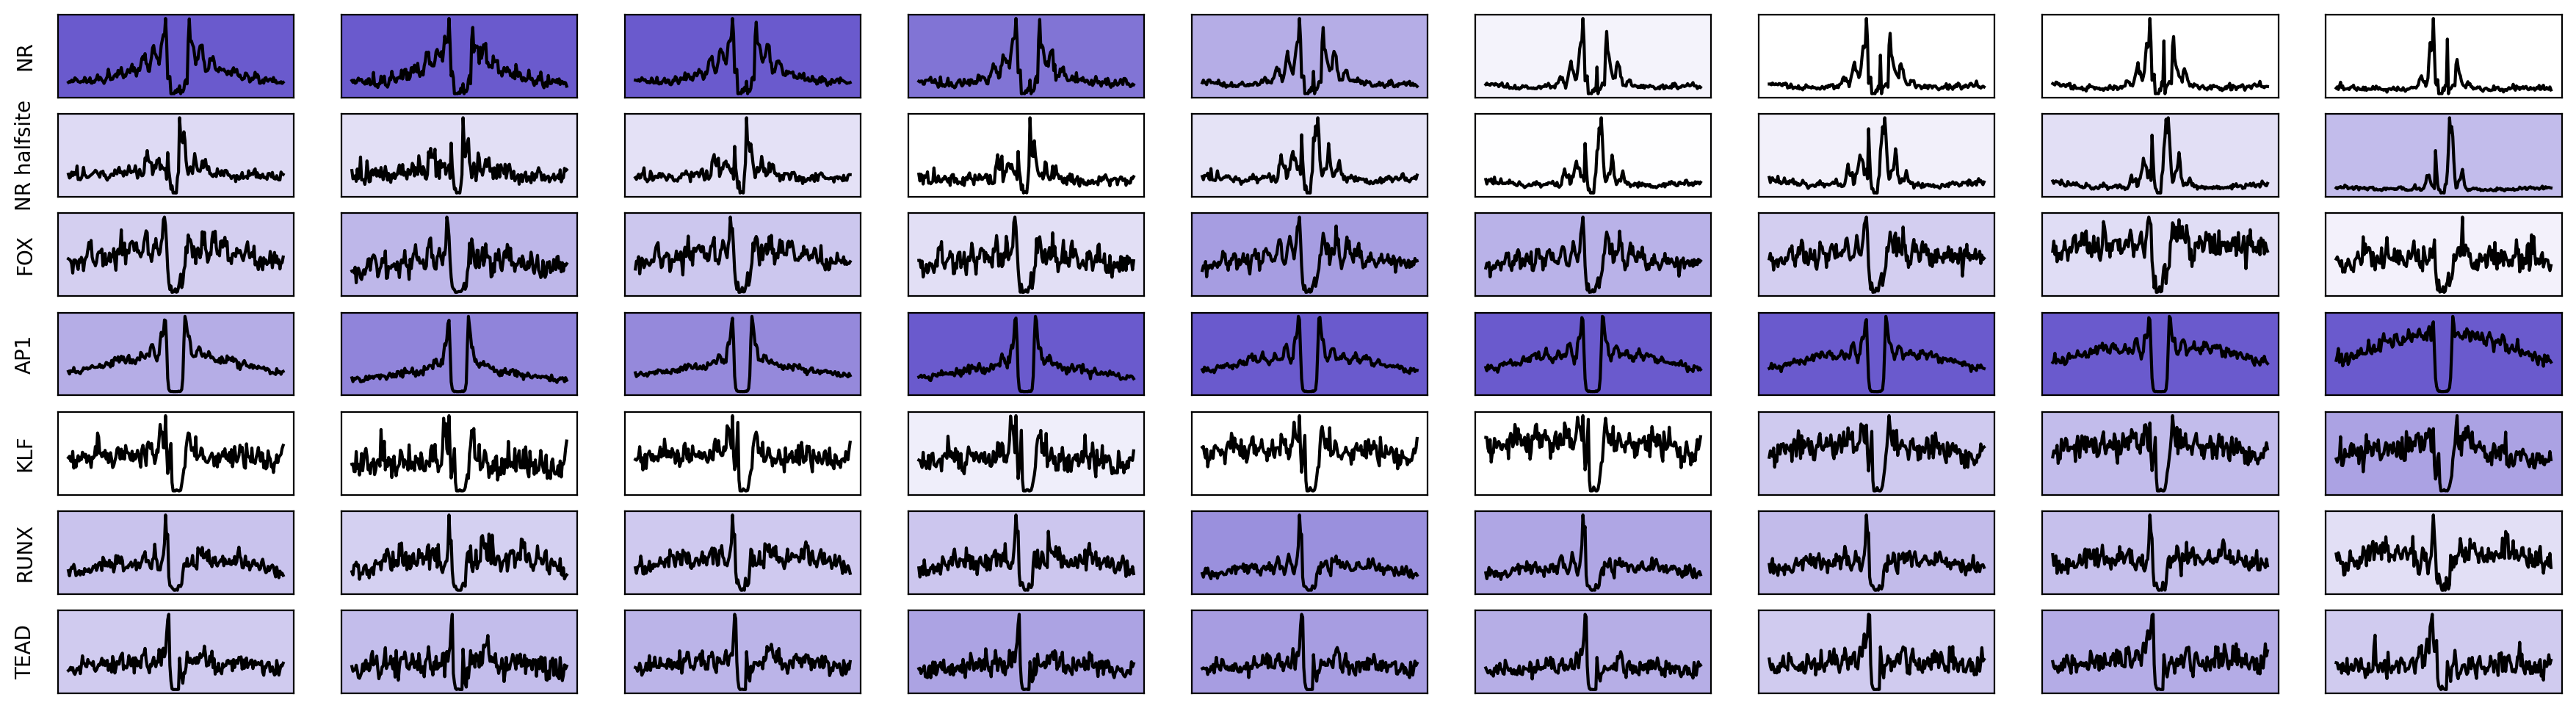

In [26]:
from itertools import repeat
maxesd = dict()
mind = dict()
lim_d = dict()
extend = []
for label in labels:
    extend.extend([label]*7)
label_sampled = pd.DataFrame(dict(zip(alldf.columns, extend)), index=['label']).T.reset_index().groupby('label').agg(lambda x: list(x)).squeeze().to_dict()

for key, values in label_sampled.items():
    max_val = alldf.loc[:, values].mean().max()
    min_val = alldf.loc[:, values].mean().min()

    maxesd.update(dict(zip(values, repeat(max_val))))
    mind.update(dict(zip(values, repeat(min_val))))
    lim_d.update(dict(zip(values, repeat(alldf.loc[:, values].max().max()))))
fig, ax = plt.subplots(7,len(mot_signals), sharex=False, figsize=(22,6))

for i, axrow in zip(['NR','halfsite', 'FOX', 'AP1', 'KLF', 'RUNX', 'TEAD'], ax, ):
    name = alldf.filter(regex=i).columns
    for namei, axcol in zip(name, axrow):
        ad = alldf.loc[:, namei]
        norm = plt.Normalize(vmin=mind[namei], vmax=maxesd[namei])

        
        axcol.plot(ad,  label=namei, c='k')
        # axcol.set_ylim([-2, lim_d[namei]])
        axcol.set_xticks('')
        axcol.set_yticklabels('')
        background_color = colormap(norm(ad.mean()))
        axcol.set_facecolor(background_color)
        axcol.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        if i ==' NR':
            axcol.set_title(namei.split('_signals_on')[0].split('trunc_')[1])
            

ax[0][0].set_ylabel("NR")
ax[1][0].set_ylabel("NR halfsite")
ax[2][0].set_ylabel("FOX")
ax[3][0].set_ylabel("AP1")
ax[4][0].set_ylabel("KLF")
ax[5][0].set_ylabel("RUNX")
ax[6][0].set_ylabel("TEAD")

fig.savefig('figures/Fig4/trunc_motif_means_ar.pdf')


In [27]:
alldf.filter(regex=i)

GR_TEAD_ar_trunc_mar_dlbd_signals_on_motifs.parquet  \
0                                             2.764454     
1                                             2.893168     
2                                             3.226871     
3                                             2.833048     
4                                             3.182752     
..                                                 ...     
195                                           2.101447     
196                                           2.860751     
197                                           3.546673     
198                                           3.442566     
199                                           3.836188     

     GR_TEAD_ar_trunc_ar_dlbd_dn100_signals_on_motifs.parquet  \
0                                             3.991904          
1                                             3.189329          
2                                             3.514670          
3                                             3.391887          
4                                             4.227228          
..                                                 ...          
195                                           1.552936          
196                                           2.485480          
197                                           4.286671          
198                                           3.614639          
199                                           4.066338          

     GR_TEAD_ar_trunc_ar_dlbd_dn150_signals_on_motifs.parquet  \
0                                             2.728193          
1                                             2.676214          
2                                             2.271227          
3                                             2.605978          
4                                             3.274092          
..                                                 ...          
195                                           1.942146          
196                                           2.344348          
197                                           3.135276          
198                                           2.522356          
199                                           3.457884          

     GR_TEAD_ar_trunc_ar_dlbd_dn200_signals_on_motifs.parquet  \
0                                             3.506600          
1                                             3.598879          
2                                             2.703285          
3                                             3.299267          
4                                             3.242577          
..                                                 ...          
195                                           2.814465          
196                                           2.630122          
197                                           4.680212          
198                                           3.853681          
199                                           4.358473          

     GR_TEAD_ar_trunc_mar_dlbd_dn300_signals_on_motifs.parquet  \
0                                             3.249796           
1                                             3.350961           
2                                             3.229599           
3                                             3.228771           
4                                             3.319809           
..                                                 ...           
195                                           2.238219           
196                                           3.309722           
197                                           4.391452           
198                                           3.717489           
199                                           4.059294           

     GR_TEAD_ar_trunc_mar_dlbd_dn350_signals_on_motifs.parquet  \
0                                             3.482623           
1               

/tmp/ipykernel_2655030/2156166386.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summits = pd.DataFrame(sigs_d).applymap(lambda x: np.max(x))
/tmp/ipykernel_2655030/2156166386.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


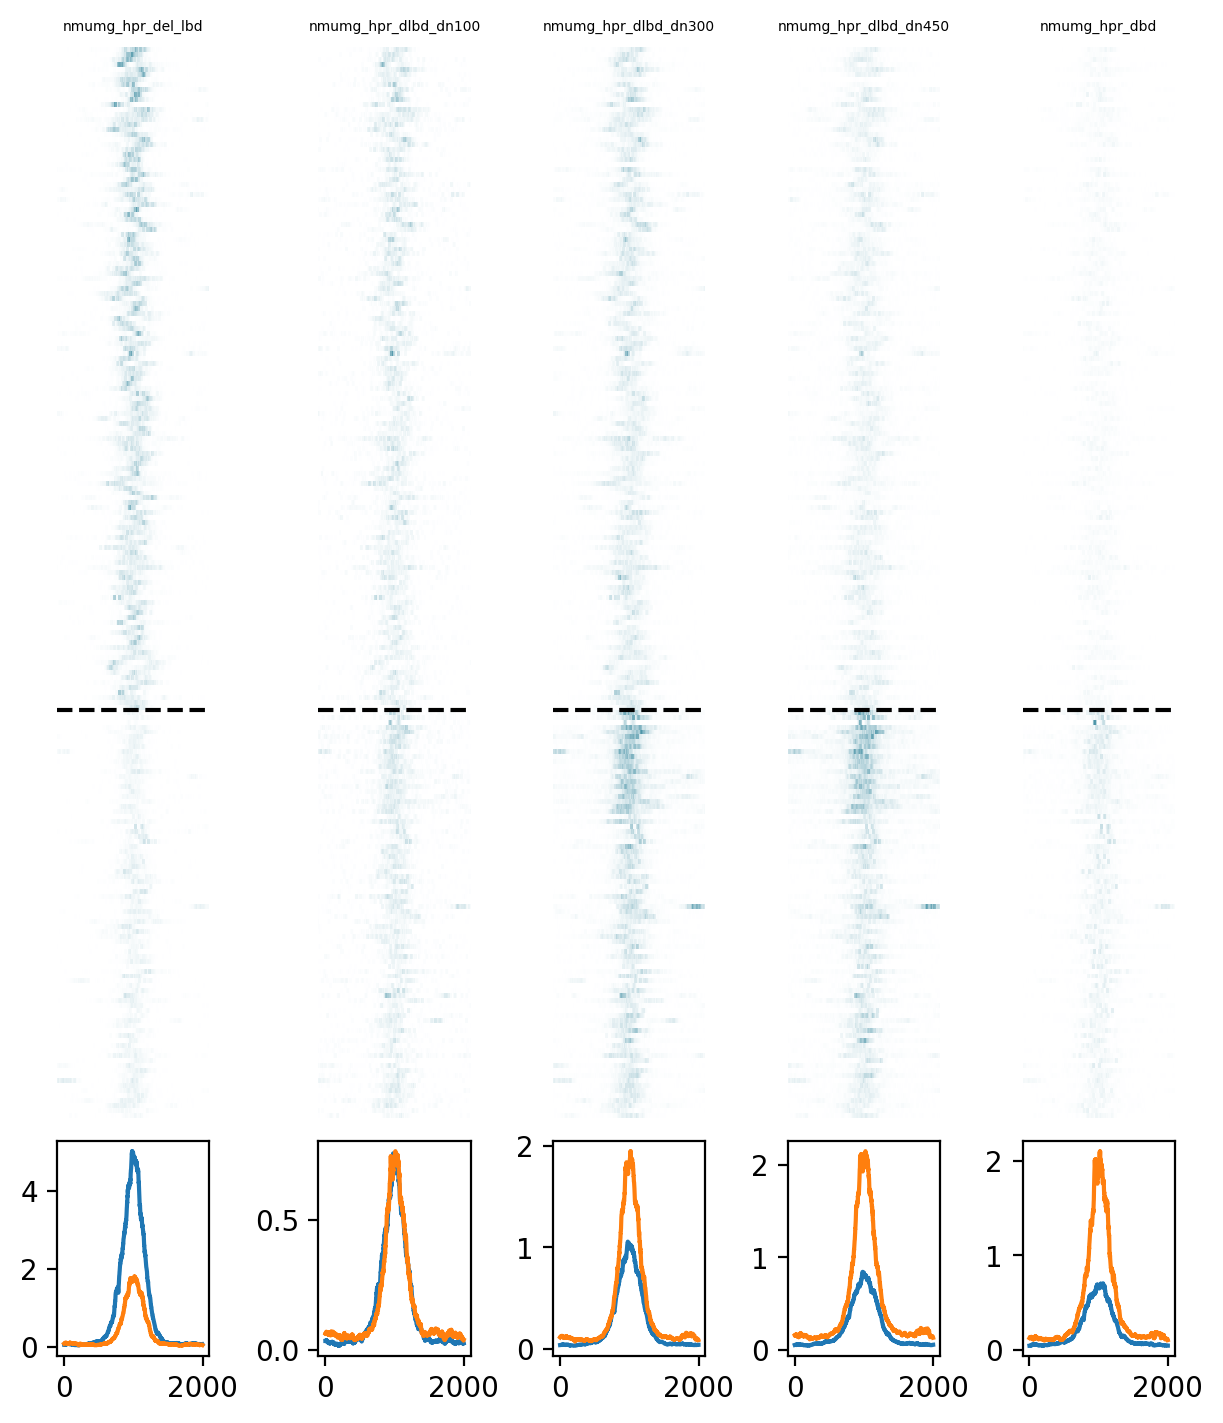

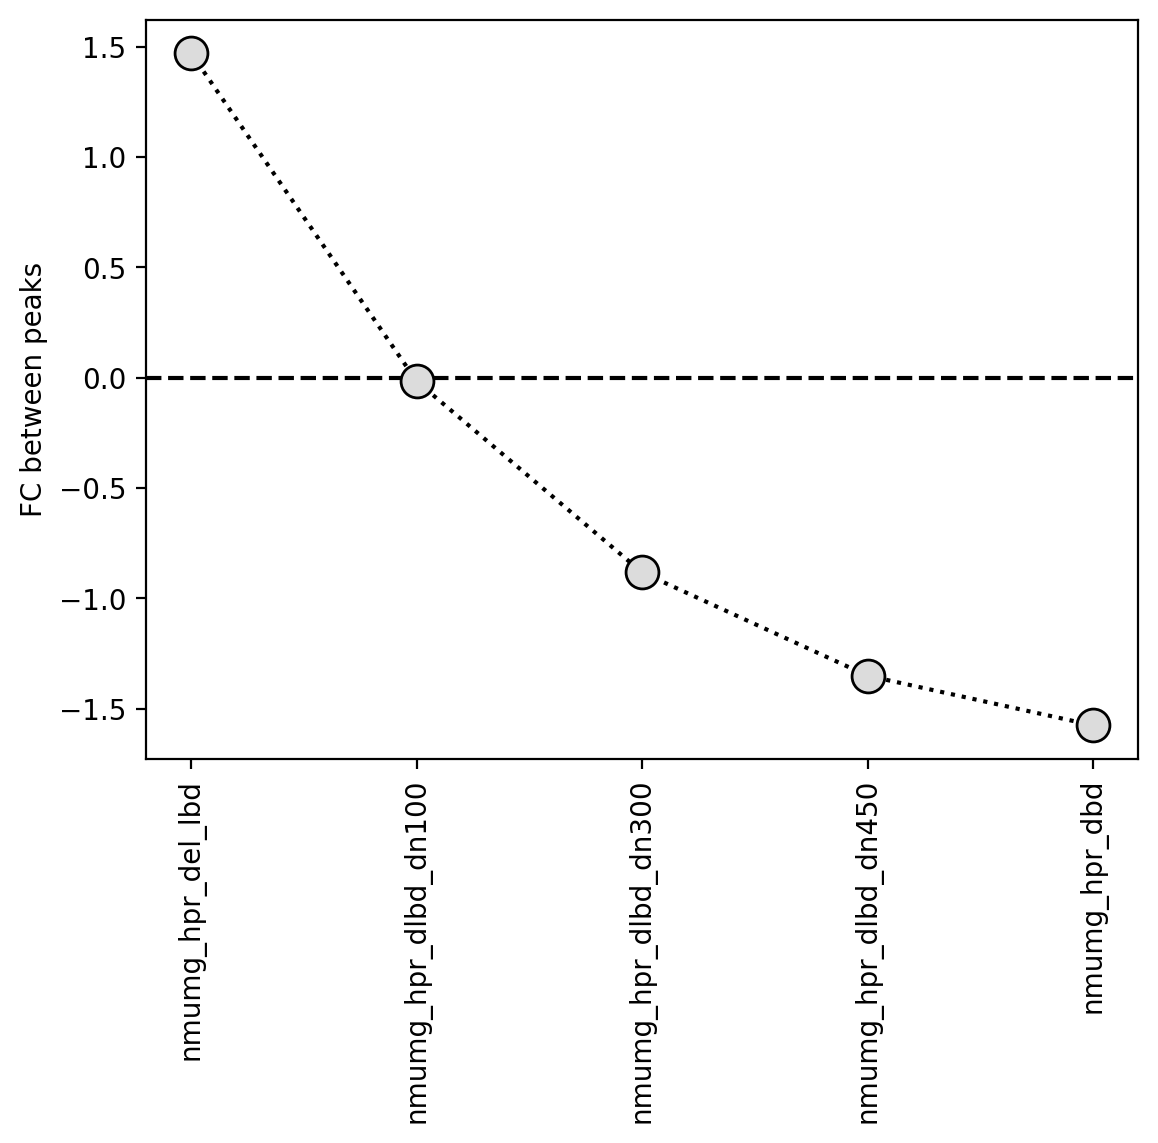

In [28]:
data2 = pd.read_parquet('cell_peaks_dbddlbdwtlig/nmumg_pr_trunc_clustered_peak_wsignals.parquet')

z = data2.set_index('nindex').loc[:, scols2]
z = (z-z.mean()) / z.std()
ind = pd.Index(np.concatenate(np.concatenate(get_targets_df(z,3,'a').values))).drop_duplicates()
ind = get_targets_df(z.loc[:, ['nmumg_hpr_del_lbd', 'nmumg_hpr_dbd']],3,'a')

sigs = ['cell_peaks_dbddlbdwtlig/signal_of_peaks_prtruncations_nmumg_hpr_del_lbd.parquet',

 'cell_peaks_dbddlbdwtlig/signal_of_peaks_prtruncations_nmumg_hpr_dlbd_dn100.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_prtruncations_nmumg_hpr_dlbd_dn300.parquet',
         'cell_peaks_dbddlbdwtlig/signal_of_peaks_prtruncations_nmumg_hpr_dlbd_dn450.parquet',
        'cell_peaks_dbddlbdwtlig/signal_of_peaks_prtruncations_nmumg_hpr_dbd.parquet',]

dl_ind = list(z.query("nmumg_hpr_del_lbd>3 & nmumg_hpr_dbd<2").sort_values(by='nmumg_hpr_del_lbd', ascending=False).index)
dbd_ind = list(z.query("nmumg_hpr_del_lbd<2 & nmumg_hpr_dbd>=3").sort_values(by='nmumg_hpr_dbd', ascending=False).index)
ind =  dl_ind+dbd_ind
fig, ax = plt.subplots(2,5, figsize=(6,7), constrained_layout=True, height_ratios=[5,1])
ax=ax.T

sigs_d = dict()

for (axi, axk),sig in zip(ax,sigs):
    sigi = pd.read_parquet(sig)
    name = sig.split('/')[-1].split('prtruncations_')[-1].split('.')[0]
    sns.heatmap(sigi.loc[ind], ax=axi,
                cmap=sns.blend_palette(['white', '#056a85'], as_cmap=True),
                vmax=sigi.loc[ind].max().max()*1.4, cbar=False,
                xticklabels=False, yticklabels=False, rasterized=True)
    axi.axhline(len(dl_ind), c='k', ls='--')
    axi.set_ylabel('')
    name = sig.split('/')[-1].split('.')[0].split('ations_')[1]
    axi.set_title(name, size=5)
    
    dlbdm = sigi.loc[dl_ind].mean()
    dbdm = sigi.loc[dbd_ind].mean()
    sigs_d[name] = {'dlbd':dlbdm, 'dbd':dbdm}
    
    axk.plot(dlbdm)
    axk.plot(dbdm)
fig.savefig('figures/Fig4/trunc_signals_htmp_pr.pdf')

summits = pd.DataFrame(sigs_d).applymap(lambda x: np.max(x))
mpeak_fc = (summits.iloc[0,:] / summits.iloc[1,:])

fig, ax = plt.subplots(1)

ax.scatter(mpeak_fc.index, np.log2(mpeak_fc), s=140, ec='k', c='gainsboro', zorder=20)
ax.plot(mpeak_fc.index, np.log2(mpeak_fc), c='k', ls=':')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(0, c='k', ls='--')
ax.set_ylabel('FC between peaks')
fig.savefig('figures/Fig4/trunc_signals_peaklog2fc_pr.pdf')


In [29]:
labels = ['nmumg_hpr_del_lbd', 'nmumg_hpr_dlbd_dn100', 'nmumg_hpr_dlbd_dn300',
       'nmumg_hpr_dlbd_dn450','nmumg_hpr_dbd', ]

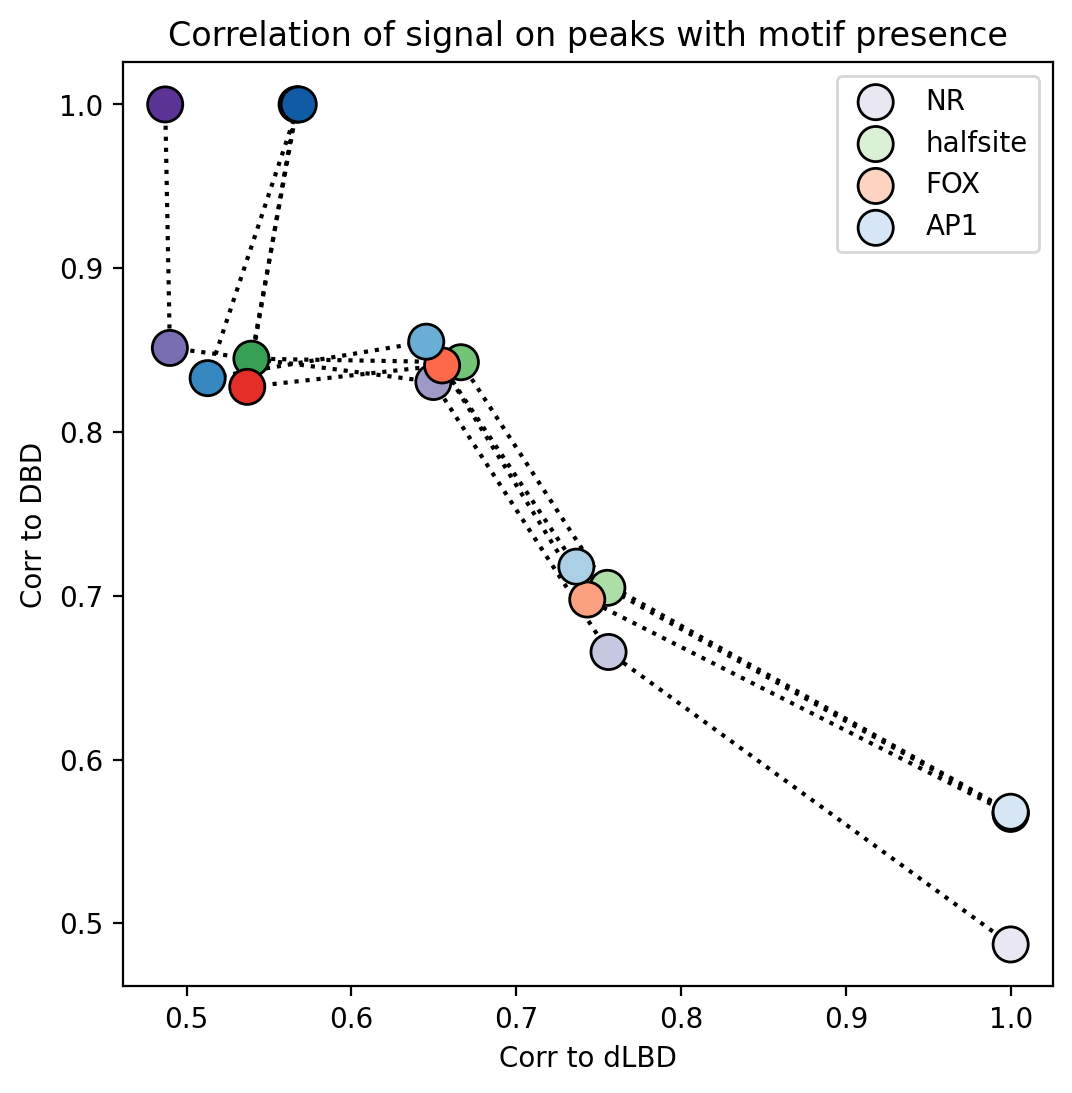

In [30]:
mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_pr_trunc_cluster', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_pr_trunc_cluster',
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_pr_trunc_cluster', 
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_pr_trunc_cluster', ]
mots_enrich = pd.concat([load_and_rename_mot(x, x.split('/')[-1]) for x in mot_folders], axis=1)
clustered_w_motifs = pd.concat([data2.set_index('nindex'), mots_enrich.fillna(0)], axis=1).fillna(0)

fig, ax = plt.subplots(1, figsize=(6,6))

ax.plot(clustered_w_motifs.query("NR_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("NR_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Purples', n_colors=len(labels)), s=160, ec='k', label='NR', zorder=20)


ax.plot(clustered_w_motifs.query("NR_hs_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_hs_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("NR_hs_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_hs_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Greens', n_colors=len(labels)), s=160, ec='k', label='halfsite', zorder=20)

ax.plot(clustered_w_motifs.query("FOX_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("FOX_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("FOX_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("FOX_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Reds', n_colors=len(labels)), s=160, ec='k', label='FOX', zorder=20)

ax.plot(clustered_w_motifs.query("AP1_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("AP1_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("AP1_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("AP1_nmumg_pr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Blues', n_colors=len(labels)), s=160, ec='k', label='AP1', zorder=20)

ax.legend()
ax.set_xlabel('Corr to dLBD')
ax.set_ylabel('Corr to DBD')
ax.set_title('Correlation of signal on peaks with motif presence')
fig.savefig('figures/Fig5/signal_corr_w_motifs_pr.pdf')

In [31]:

# mot_signals = sorted(glob.glob('cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_*_signals_on_motifs.parquet'))


# mot_signals = [
#  'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_del_lbd_signals_on_motifs.parquet',
#  'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_dlbd_dn100_signals_on_motifs.parquet',
#  'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_dlbd_dn300_signals_on_motifs.parquet',
#  'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_dlbd_dn450_signals_on_motifs.parquet',
# 'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_dbd_signals_on_motifs.parquet',]

# alldf = pd.DataFrame()

# for sig in mot_signals:
#     a = pd.read_parquet(sig)
#     analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))].groupby('id', group_keys=False)\
#     .apply(filter_top_quantile, 0.9).groupby('id').mean().T
#     analyzed.columns = [x+ sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '')\
#                         for x in analyzed.columns]
#     alldf = pd.concat([alldf, analyzed], axis=1)

# fig = plt.figure(figsize=(33,8), constrained_layout=True, dpi=200)    

# subf = fig.subfigures(1,4, width_ratios=[10,2,5,5])

# # fig, ax = plt.subplots(4,9,figsize=(20,8), constrained_layout=True, sharex=False)

# ax = subf[0].subplots(4,len(mot_signals), sharex=False)

# ax= ax

# lens_big_dict = dict()
# enrich_big_dict = dict()

# for i, axrow,c in zip(['NR','halfsite', 'FOX', 'AP1'], ax, ['purple', '#56e15e', 'salmon', '#cee156']):
#         name = alldf.filter(regex=i).columns
        
#         for namei, axcol in zip(name, axrow):
#             ad = alldf.loc[:, namei]
#             enrich_big_dict[namei] = np.log2((ad.iloc[list(np.arange(70,90)) + list(np.arange(110,130))].sum() /\
#     ad.iloc[list(np.arange(0,20)) + list(np.arange(180,200))].sum()))
#             rfunc = lambda x: find_gap_length(x.iloc[np.arange(75,125)], x.iloc[np.arange(75,125)].median())
#             lendict = {namei:rfunc(ad)}
#             lens_big_dict[namei] = lendict
#             axcol.plot(ad,  label=namei, c=c)
#             axcol.set_xticks('')
#             axcol.set_title(namei.split('_signals_on')[0].split('trunc_')[1])
            
# for i in np.arange(len(mot_signals)):
#     ax[1][i].sharey(ax[0][i])
#     ax[2][i].sharey(ax[0][i])
#     ax[3][i].sharey(ax[0][i])
# ax[0][0].set_ylabel("NR")
# ax[1][0].set_ylabel("NR halfsite")
# ax[2][0].set_ylabel("FOX")
# ax[3][0].set_ylabel("AP1")



# len_df = pd.DataFrame(pd.DataFrame(lens_big_dict).mean(axis=1))

# len_df.loc[:,'motif'] = [x[0] for x in len_df.index.str.split('_trunc_')]
# len_df.loc[:, 'tf'] = [x[1] for x in len_df.index.str.split('_trunc_')]
# len_df = len_df.pivot(columns='motif', index='tf', values=0)

# ind = [
#        'hpr_del_lbd_signals_on_motifs.parquet',
#        'hpr_dlbd_dn100_signals_on_motifs.parquet',
#        'hpr_dlbd_dn300_signals_on_motifs.parquet',
#        'hpr_dlbd_dn450_signals_on_motifs.parquet',
# 'hpr_dbd_signals_on_motifs.parquet',]
# len_df = len_df.loc[ind, :]


# enrich_df = pd.DataFrame(enrich_big_dict, index=['enrich']).T
# enrich_df.loc[:,'motif'] = [x[0] for x in enrich_df.index.str.split('_trunc_')]
# enrich_df.loc[:, 'tf'] = [x[1] for x in enrich_df.index.str.split('_trunc_')]
# enrich_df = enrich_df.pivot(columns='motif', index='tf', values='enrich')


# enrich_df = enrich_df.loc[ind, :]

# ax= subf[1].subplots(1, )
# sns.heatmap(enrich_df, cmap='GnBu',
#             linewidth=1, linecolor='k', annot=len_df.values, vmin=1, vmax=2, ax=ax)

# ax.set_yticklabels('')

# axfoot, corrax = subf[2].subplots(2,1, sharex=True, )
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_NRpr'], label='NR', c=enrich_df.loc[:, 'GR_NRpr'], cmap='Purples', vmin=1, vmax=2, ec='k', s=120)
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_AP1pr'], label='AP1', c=enrich_df.loc[:, 'GR_AP1pr'], cmap='Blues', vmin=1, vmax=2, ec='k', s=120)
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_FOXpr'], label='FOX', c=enrich_df.loc[:, 'GR_FOXpr'], cmap='Reds', vmin=1, vmax=2, ec='k', s=120)
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_halfsitepr'], label='halfsite', c=enrich_df.loc[:, 'GR_halfsitepr'], cmap='Greens', vmin=1, vmax=2, ec='k', s=120)


# axfoot.plot(len_df.index, len_df.loc[:, 'GR_NRpr'], c='gray', ls='--', lw=.5)
# axfoot.plot(len_df.index, len_df.loc[:, 'GR_AP1pr'], c='gray', ls='--', lw=.5)
# axfoot.plot(len_df.index, len_df.loc[:, 'GR_FOXpr'], c='gray', ls='--', lw=.5)
# axfoot.plot(len_df.index, len_df.loc[:, 'GR_halfsitepr'], c='gray', ls='--', lw=.5)

# axfoot.legend()
# axfoot.set_xticks(np.arange(len(mot_signals)), ['hpr_del_lbd', 'hpr_dlbd_dn100', 'hpr_dlbd_dn300',
#        'hpr_dlbd_dn450', 'hpr_dbd', ], rotation=90)
    

# mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_pr_trunc_cluster', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_pr_trunc_cluster',
# 'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_pr_trunc_cluster', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_pr_trunc_cluster', ]
# mots_enrich = pd.concat([load_and_rename_mot(x, x.split('/')[-1]) for x in mot_folders], axis=1)
# clustered_w_motifs = pd.concat([data2.set_index('nindex'), mots_enrich.fillna(0)], axis=1).fillna(0)
# ax = subf[3].subplots(1)
# corr = clustered_w_motifs.query("NR_nmumg_pr_trunc_cluster>0").loc[:, mpeak_fc.index].corr()
# sns.heatmap(corr,
#             cmap='GnBu', ax=ax)
# corrax.scatter(len_df.index, corr.nmumg_hpr_del_lbd,c='salmon', s=120)
# corrax.scatter(len_df.index, corr.nmumg_hpr_dbd,c='darkslateblue', s=120)

# corrax.plot(len_df.index, corr.nmumg_hpr_del_lbd, c='gray', ls='--')
# corrax.plot(len_df.index, corr.nmumg_hpr_dbd, c='gray', ls='--')

# corrax.set_xticks(np.arange(len(mot_signals)), ['hpr_del_lbd', 'hpr_dlbd_dn100', 'hpr_dlbd_dn300',
#        'hpr_dlbd_dn450','hpr_dbd', ], rotation=90)
#     # fig.savefig('figures/footshape.pdf')

In [32]:
mot_signals = [
 'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_del_lbd_signals_on_motifs.parquet',
 'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_dlbd_dn100_signals_on_motifs.parquet',
 'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_dlbd_dn300_signals_on_motifs.parquet',
 'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_dlbd_dn450_signals_on_motifs.parquet',
'cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_hpr_dbd_signals_on_motifs.parquet',]

In [33]:
def proc_signals(mot_signals):
    alldf = pd.DataFrame()
    allfoot_df = pd.DataFrame()
    for sig in mot_signals:
        a = pd.read_parquet(sig)
        analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))]
        foot_df = pd.DataFrame()
        for idi in analyzed.id.unique():
            proc_df = filter_top_quantile(analyzed[analyzed.id == idi].loc[:, np.arange(200).astype(str)], 0.9)
            top5_cols = (
                    proc_df.iloc[:, :200]
                    .mean()
                    .sort_values(ascending=False)
                    .iloc[:5]
                    .index
                    .astype(int)
                )
            null = proc_df.iloc[:, top5_cols].values.flatten()
            func = lambda x: stats.mannwhitneyu(null, x)[1]
            calc_pvs = proc_df.iloc[:, :200].apply(func, axis=0)
            calc_pvs[(calc_pvs == 0)] = calc_pvs[~(calc_pvs == 0)].min()
            m10log10pval = (-10 * np.log10(calc_pvs))

            foot  = pd.DataFrame(compute_footprint_lengths(m10log10pval.index.astype(int), m10log10pval, np.arange(0.05,1.05,0.05)), index=[idi]).T
            foot_df = pd.concat([foot_df, foot], axis=1)
        analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
        analyzed.columns = [x+ '_' + sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '') for x in analyzed.columns]
        foot_df.columns = [x+ '_' + sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '') for x in foot_df.columns]

        alldf = pd.concat([alldf, analyzed], axis=1)
        allfoot_df = pd.concat([allfoot_df, foot_df], axis=1)
        
    return (alldf, allfoot_df)



In [34]:
alldf, allfoot_df = proc_signals(mot_signals)
labels = ['hpr_del_lbd', 'hpr_dlbd_dn100', 'hpr_dlbd_dn300',
       'hpr_dlbd_dn450','hpr_dbd', ]

/tmp/ipykernel_2655030/168397341.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_2655030/168397341.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_2655030/1

In [35]:
def plot_foot(df, labels):
    unstacked = df.unstack().reset_index()
    unstacked.loc[:, 'motif'] = unstacked.level_0.apply(lambda x: x.split('_')[1])
    unstacked.loc[:, 'factor'] = unstacked.level_0.apply(lambda x: x.split('_sig')[0].split('trunc_')[1])
    # unstacked.loc[:, 'type'] = unstacked.factor.apply(lambda x: '_'.join(x.split('_')[1:]))
    unstacked = unstacked.drop('level_0', axis=1)
    unstacked.replace('del_lbd', 'dlbd', inplace=True)

    g = sns.catplot(
        unstacked, kind="violin",
        col="motif", y=0, x="factor",
        height=4, aspect=.8, sharey=True,native_scale=True, palette='GnBu'
    )
    g.set_axis_labels("", "Footprint size")
    g.set_xticklabels(labels, rotation=90)
    g.set(ylim=(0, 40))

    g.set_titles("{col_name} {col_var}")
    g.fig.suptitle("Footprint size analyses", y=1.05)  # Adjust y to control the vertical position
    return g

/tmp/ipykernel_2655030/1605342044.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


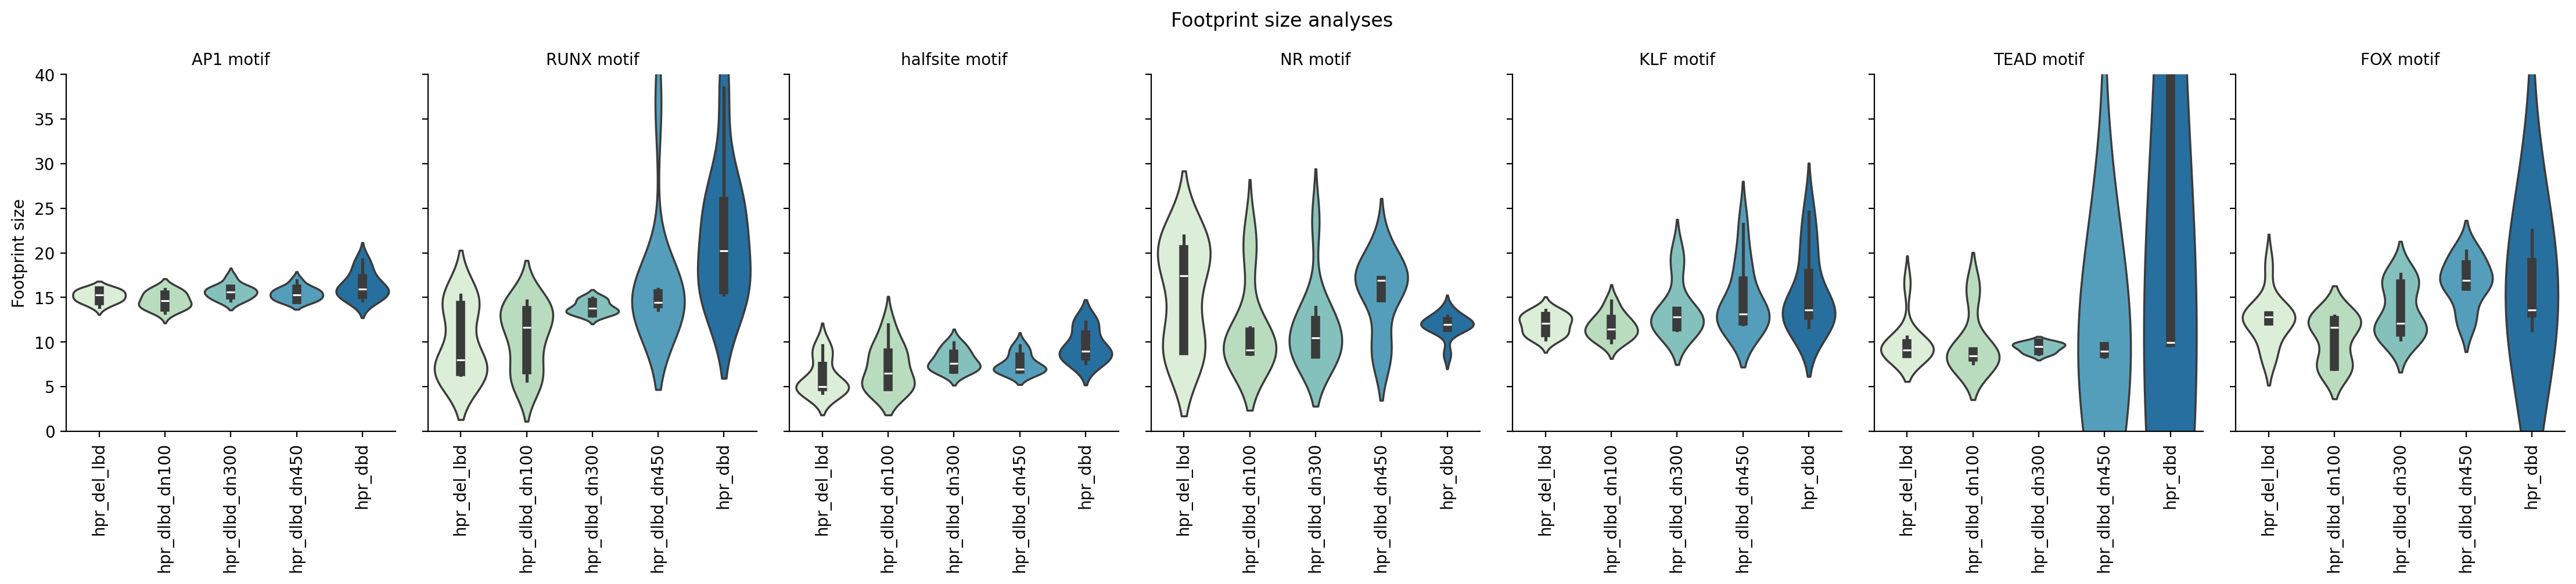

In [36]:
g = plot_foot(allfoot_df.iloc[:10, :], labels)

g.figure.savefig('figures/Fig4/trunc_violins_pr.pdf')

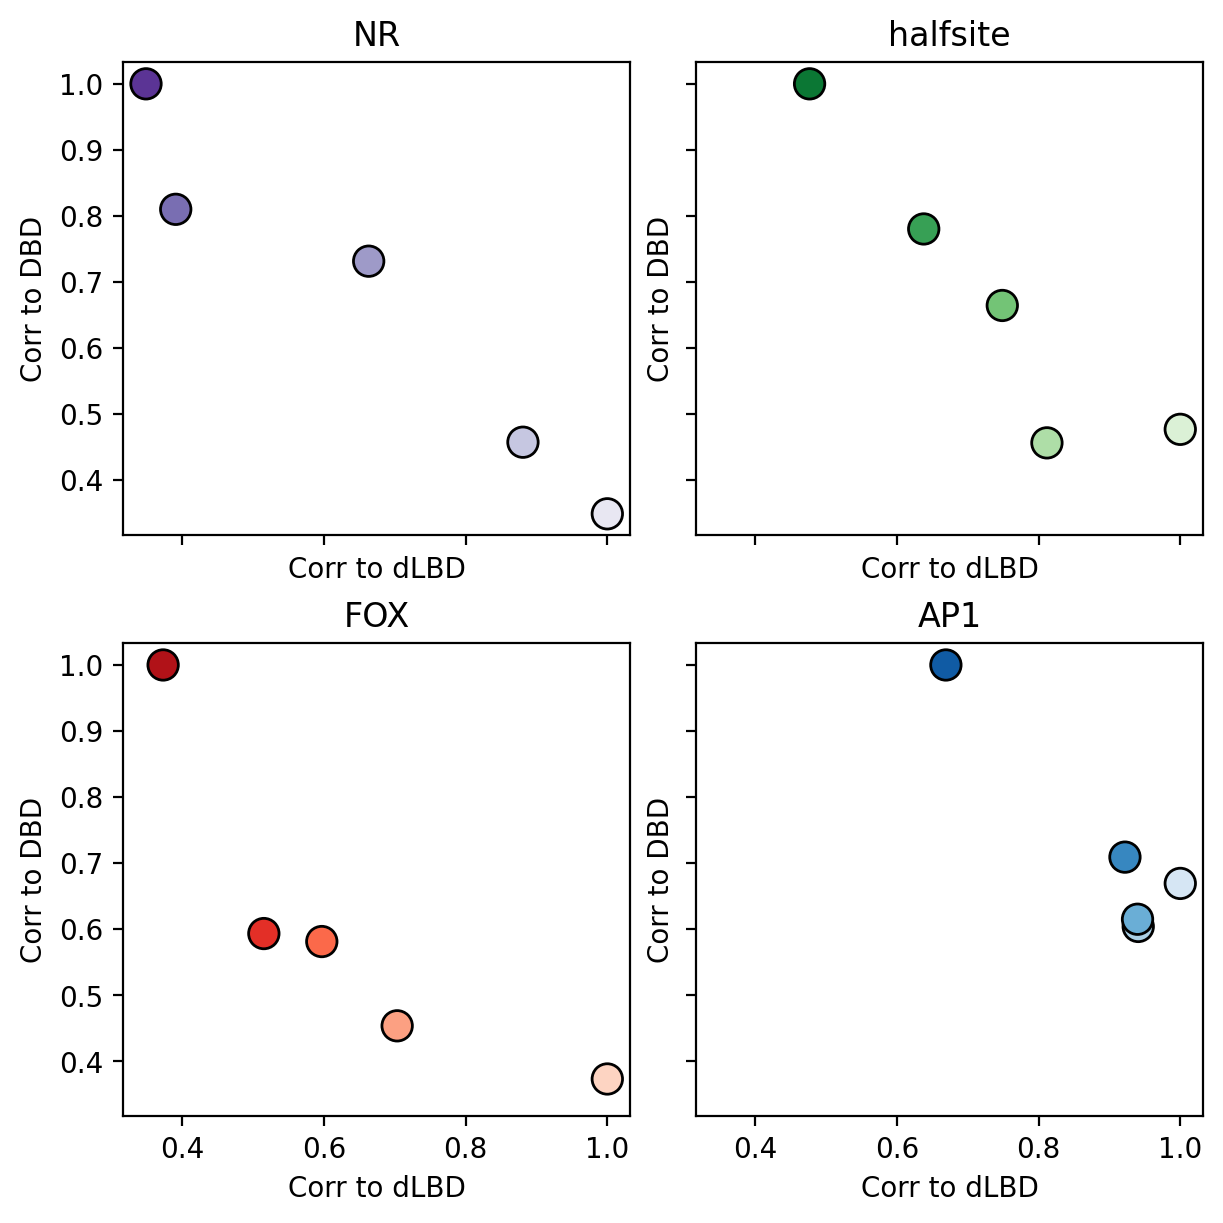

In [37]:
ids=['NR', 'halfsite', 'FOX', 'AP1']

cd = sns.color_palette('Purples', n_colors=len(labels))
all_corr = alldf.corr()

fig, ax = plt.subplots(2,2, sharex=True, sharey=True, constrained_layout=True, figsize=(6,6))
ax= ax.flatten()
ax[0].scatter(alldf.filter(regex=ids[0]).corr().iloc[:, 0], alldf.filter(regex=ids[0]).corr().iloc[:, -1], c=sns.color_palette('Purples', n_colors=len(labels)), s=120, ec='k', label='NR')
ax[1].scatter(alldf.filter(regex=ids[1]).corr().iloc[:, 0], alldf.filter(regex=ids[1]).corr().iloc[:, -1], c=sns.color_palette('Greens', n_colors=len(labels)), s=120, ec='k', label='halfsite')
ax[2].scatter(alldf.filter(regex=ids[2]).corr().iloc[:, 0], alldf.filter(regex=ids[2]).corr().iloc[:, -1], c=sns.color_palette('Reds', n_colors=len(labels)), s=120, ec='k', label='FOX')
ax[3].scatter(alldf.filter(regex=ids[3]).corr().iloc[:, 0], alldf.filter(regex=ids[3]).corr().iloc[:, -1], c=sns.color_palette('Blues', n_colors=len(labels)), s=120, ec='k', label='AP1')

for i, axi in zip(ids, ax):
    axi.set_title(i)
    axi.set_xlabel('Corr to dLBD')
    axi.set_ylabel('Corr to DBD')

fig.savefig('figures/Fig4/trunc_shape_corr_pr.pdf')


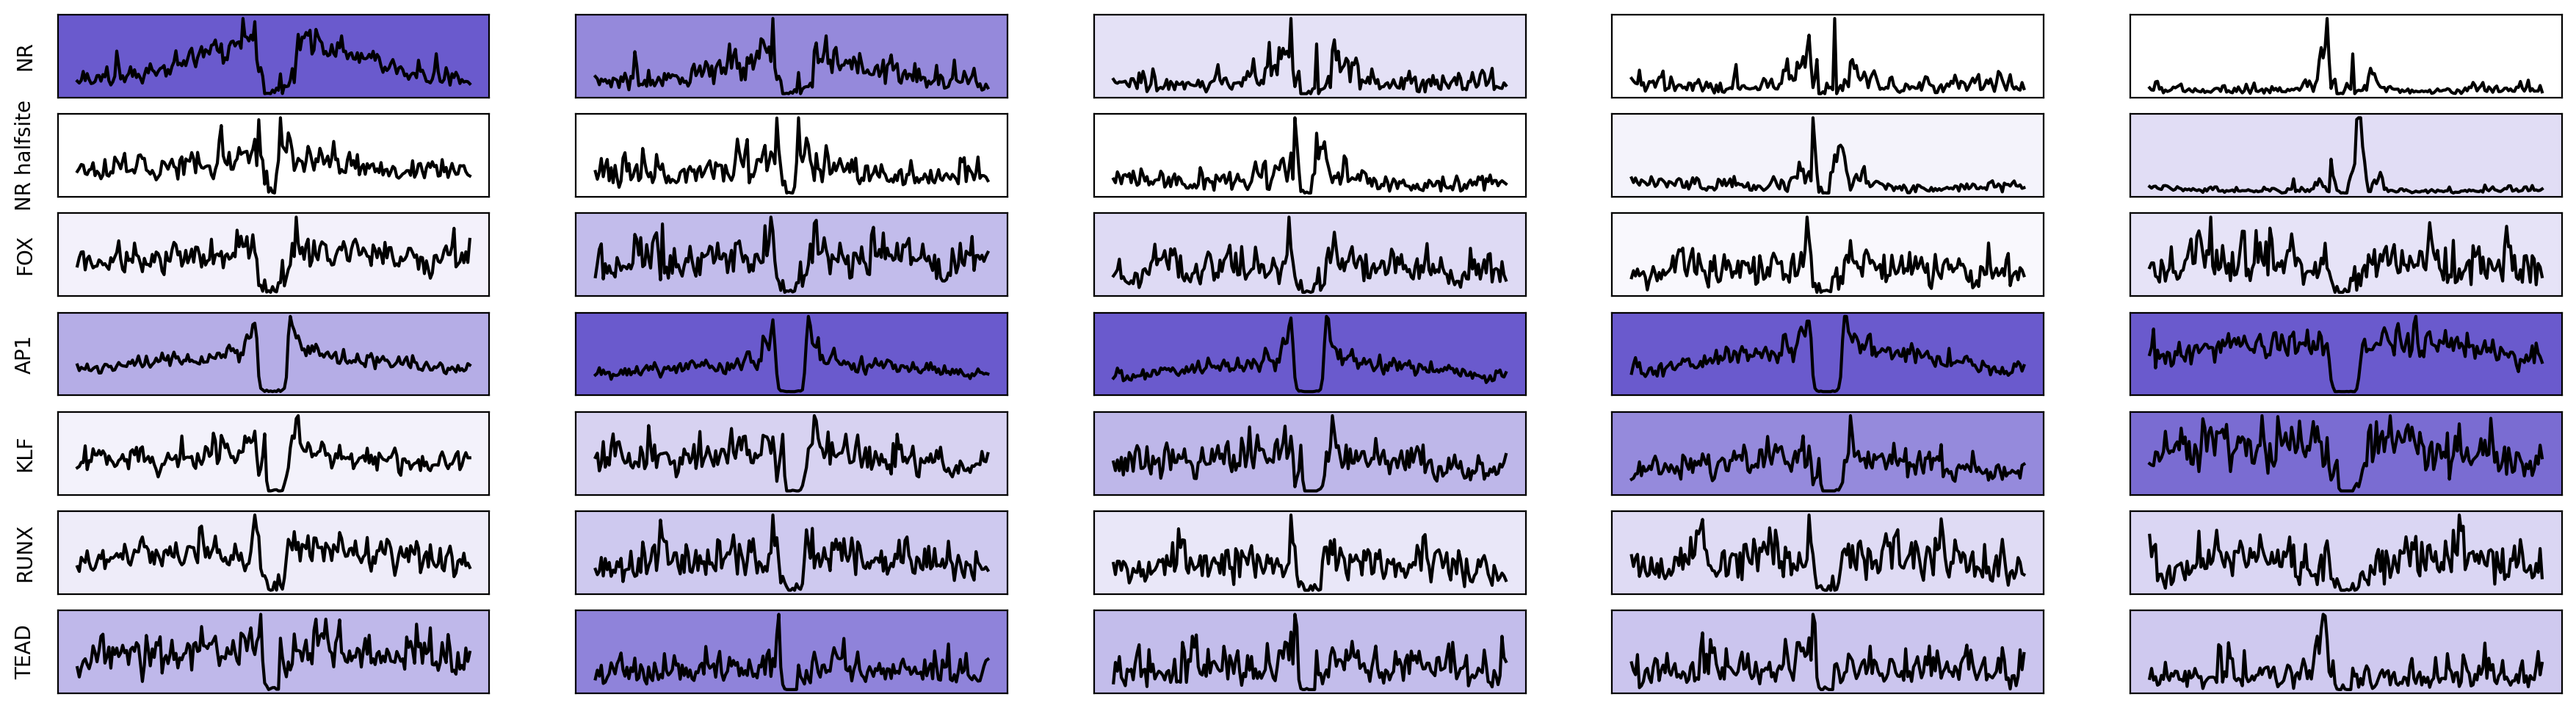

In [38]:
from itertools import repeat
maxesd = dict()
mind = dict()
lim_d = dict()
extend = []
for label in labels:
    extend.extend([label]*7)
label_sampled = pd.DataFrame(dict(zip(alldf.columns, extend)), index=['label']).T.reset_index().groupby('label').agg(lambda x: list(x)).squeeze().to_dict()

for key, values in label_sampled.items():
    max_val = alldf.loc[:, values].mean().max()
    min_val = alldf.loc[:, values].mean().min()

    maxesd.update(dict(zip(values, repeat(max_val))))
    mind.update(dict(zip(values, repeat(min_val))))
    lim_d.update(dict(zip(values, repeat(alldf.loc[:, values].max().max()))))
fig, ax = plt.subplots(7,len(mot_signals), sharex=False, figsize=(22,6))

for i, axrow in zip(['NR','halfsite', 'FOX', 'AP1', 'KLF', 'RUNX', 'TEAD'], ax, ):
    name = alldf.filter(regex=i).columns
    for namei, axcol in zip(name, axrow):
        ad = alldf.loc[:, namei]
        norm = plt.Normalize(vmin=mind[namei], vmax=maxesd[namei])

        
        axcol.plot(ad,  label=namei, c='k')
        # axcol.set_ylim([-2, lim_d[namei]])
        axcol.set_xticks('')
        axcol.set_yticklabels('')
        background_color = colormap(norm(ad.mean()))
        axcol.set_facecolor(background_color)
        axcol.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        if i ==' NR':
            axcol.set_title(namei.split('_signals_on')[0].split('trunc_')[1])
            

ax[0][0].set_ylabel("NR")
ax[1][0].set_ylabel("NR halfsite")
ax[2][0].set_ylabel("FOX")
ax[3][0].set_ylabel("AP1")
ax[4][0].set_ylabel("KLF")
ax[5][0].set_ylabel("RUNX")
ax[6][0].set_ylabel("TEAD")

fig.savefig('figures/Fig4/trunc_motif_means_pr.pdf')


In [39]:
z.columns

Index(['nmumg_hpr_del_lbd', 'nmumg_hpr_dlbd_dn100', 'nmumg_hpr_dlbd_dn300',
       'nmumg_hpr_dlbd_dn450', 'nmumg_hpr_dbd'],
      dtype='object')

/tmp/ipykernel_2655030/4288368789.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summits = pd.DataFrame(sigs_d).applymap(lambda x: np.max(x))
/tmp/ipykernel_2655030/4288368789.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


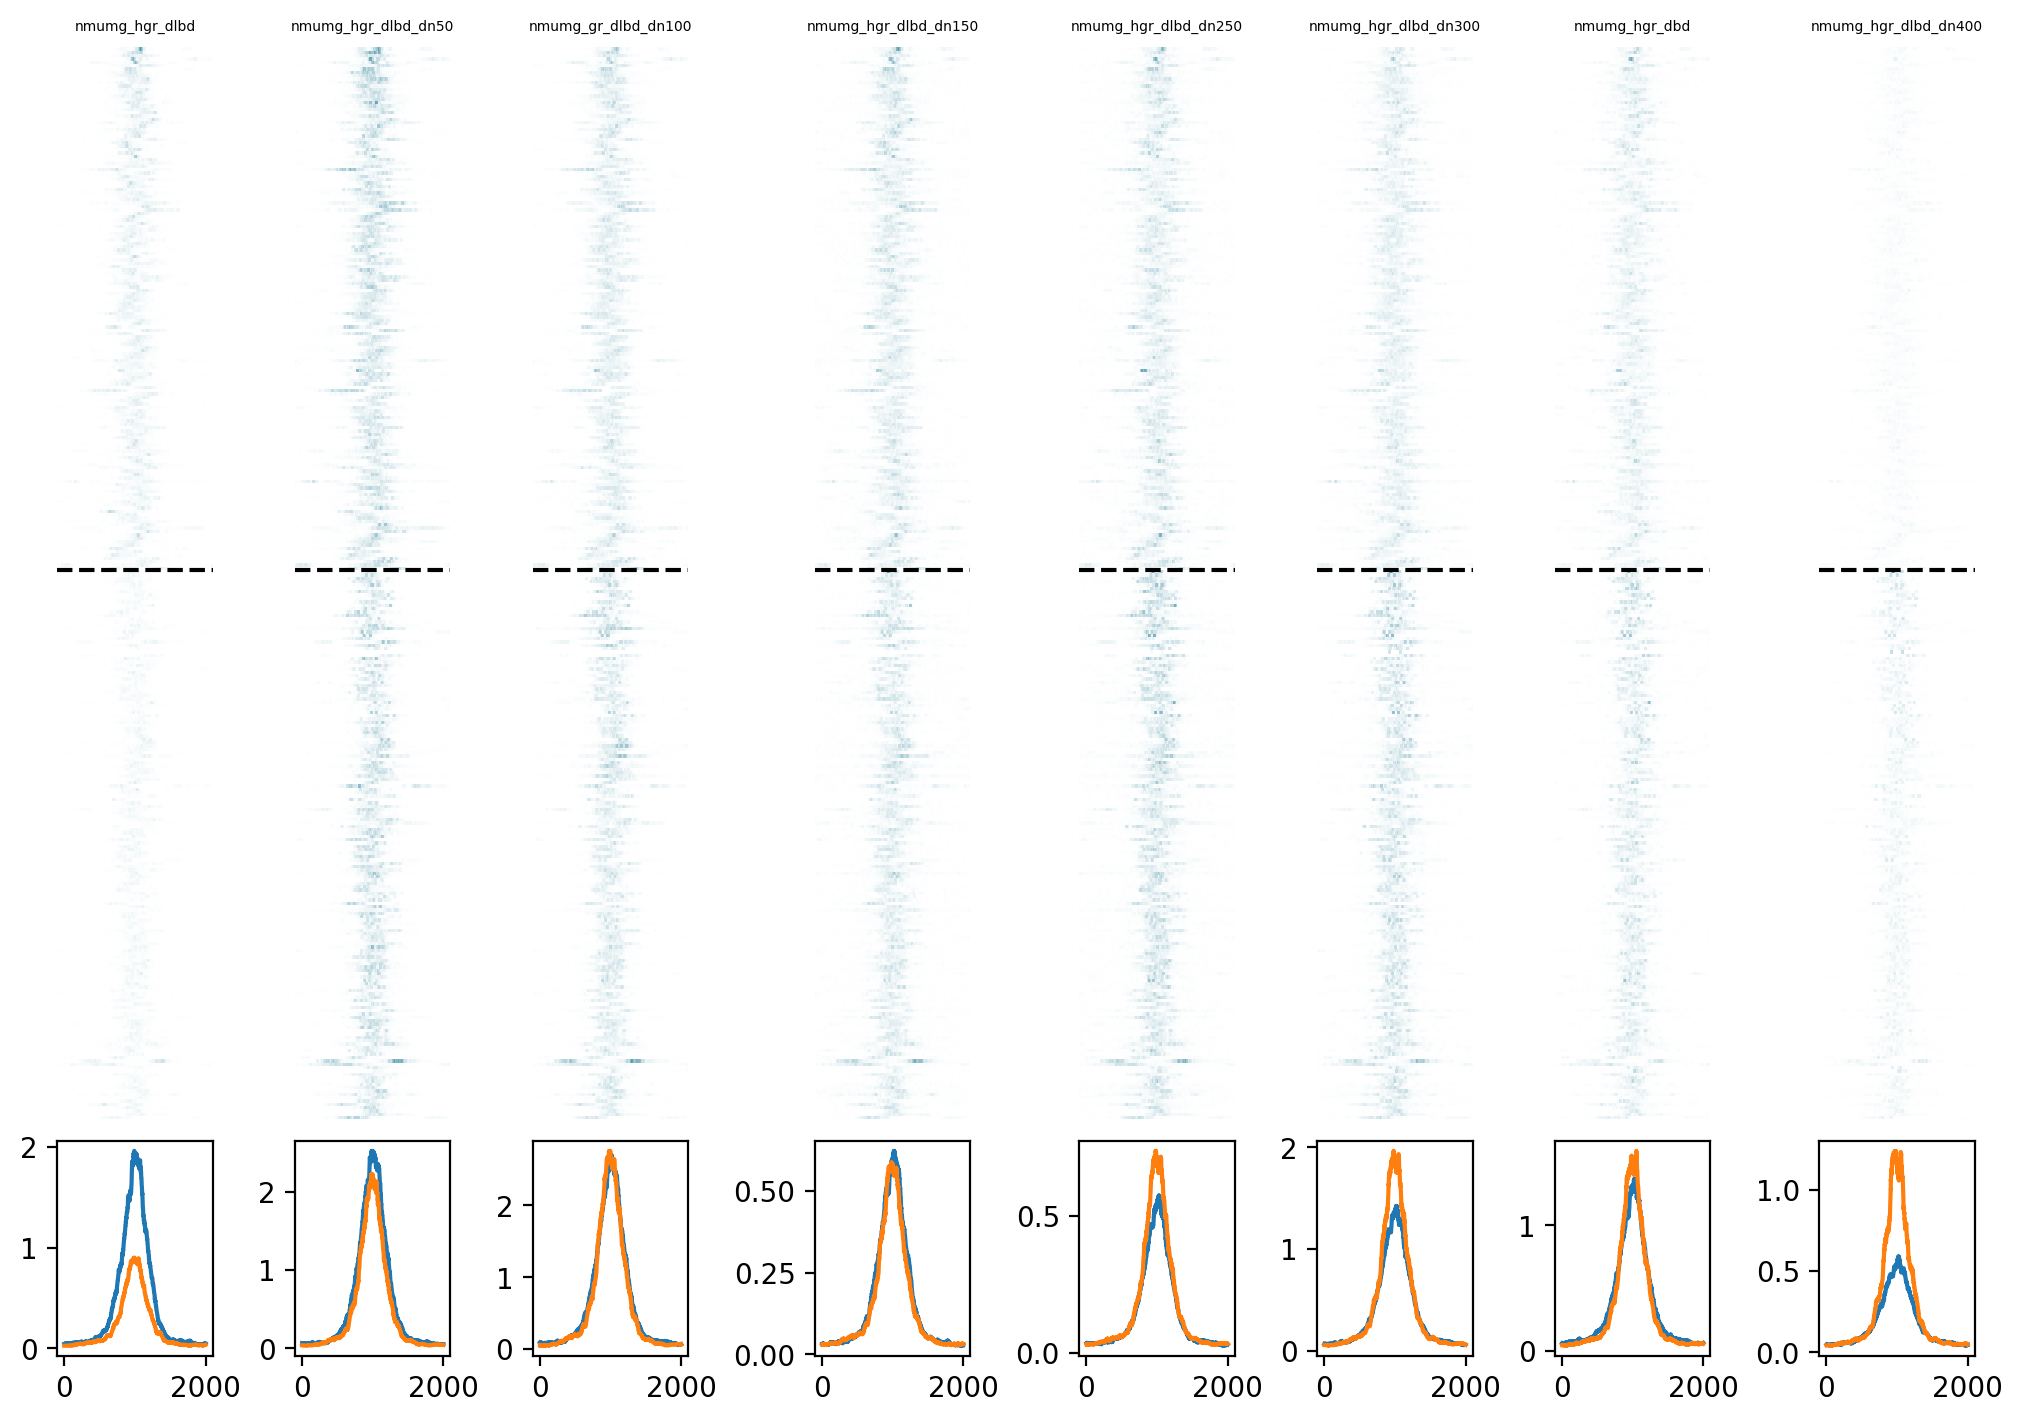

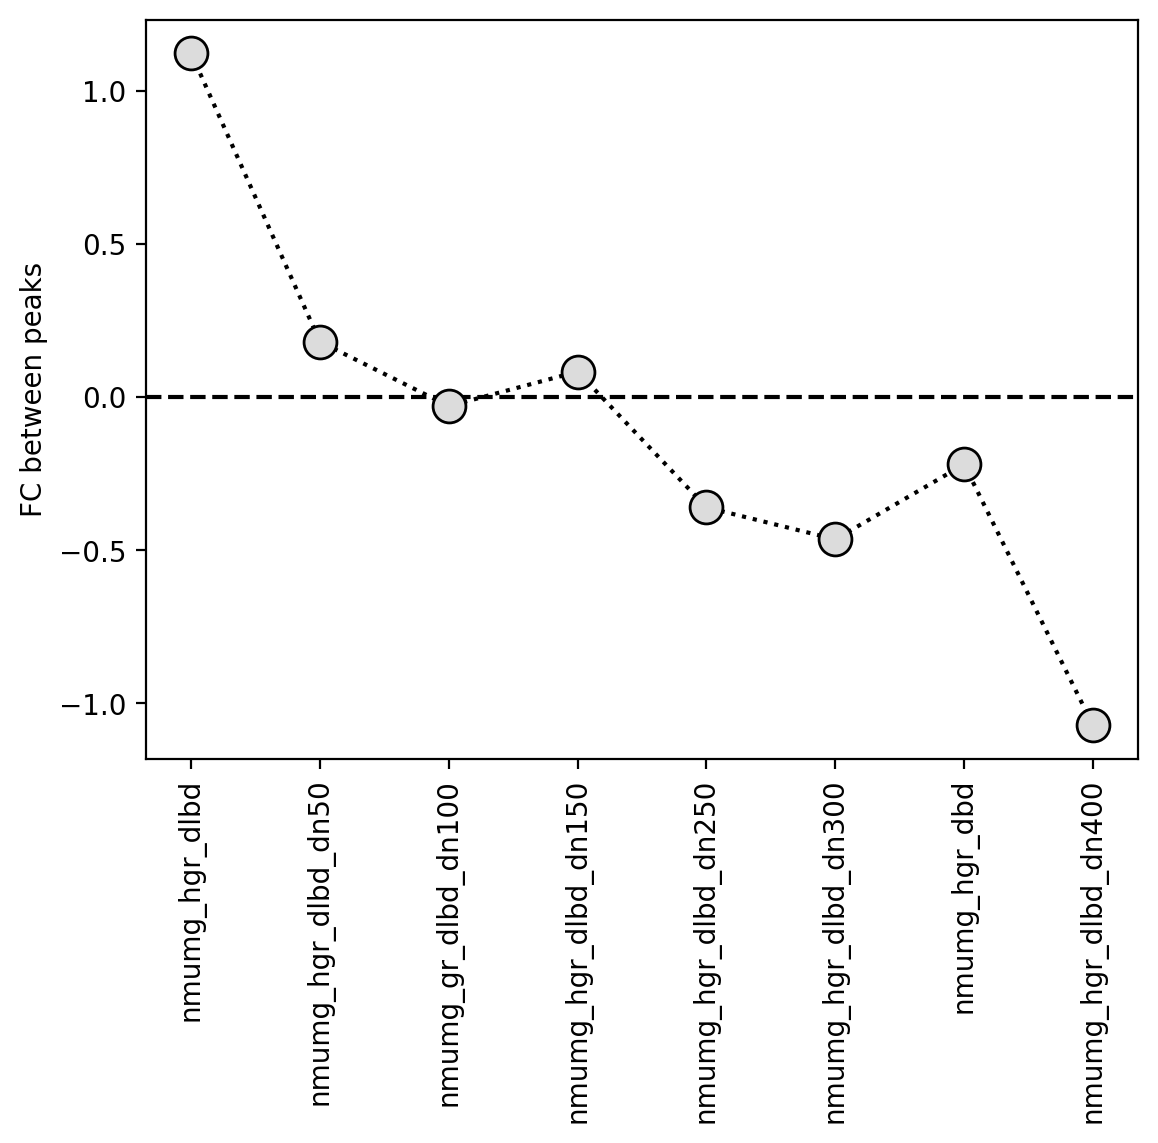

In [40]:
data3 = pd.read_parquet('cell_peaks_dbddlbdwtlig/nmumg_gr_trunc_clustered_peak_wsignals.parquet')

z = data3.set_index('nindex').loc[:, scols3]
z = (z-z.mean()) / z.std()
ind = pd.Index(np.concatenate(np.concatenate(get_targets_df(z,3,'a').values))).drop_duplicates()
ind = get_targets_df(z.loc[:, ['nmumg_hgr_dlbd', 'nmumg_hgr_dlbd_dn400']],3,'a')

dl_ind = list(z.query("nmumg_hgr_dlbd>3 & nmumg_hgr_dlbd_dn400<2").sort_values(by='nmumg_hgr_dlbd', ascending=False).index)
dbd_ind = list(z.query("nmumg_hgr_dlbd<2 & nmumg_hgr_dlbd_dn400>=3").sort_values(by='nmumg_hgr_dlbd_dn400', ascending=False).index)
ind =  dl_ind+dbd_ind

sigs = [ 'cell_peaks_dbddlbdwtlig/signal_of_peaks_grtruncations_nmumg_hgr_dlbd.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_grtruncations_nmumg_hgr_dlbd_dn50.parquet',
        'cell_peaks_dbddlbdwtlig/signal_of_peaks_grtruncations_nmumg_gr_dlbd_dn100.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_grtruncations_nmumg_hgr_dlbd_dn150.parquet',
         'cell_peaks_dbddlbdwtlig/signal_of_peaks_grtruncations_nmumg_hgr_dlbd_dn250.parquet',
 'cell_peaks_dbddlbdwtlig/signal_of_peaks_grtruncations_nmumg_hgr_dlbd_dn300.parquet',
        'cell_peaks_dbddlbdwtlig/signal_of_peaks_grtruncations_nmumg_hgr_dbd.parquet',
         'cell_peaks_dbddlbdwtlig/signal_of_peaks_grtruncations_nmumg_hgr_dlbd_dn400.parquet',

]

fig, ax = plt.subplots(2,8, figsize=(10,7), constrained_layout=True, height_ratios=[5,1])
ax=ax.T

sigs_d = dict()

for (axi, axk),sig in zip(ax,sigs):
    sigi = pd.read_parquet(sig)
    name = sig.split('/')[-1].split('prtruncations_')[-1].split('.')[0]
    sns.heatmap(sigi.loc[ind], ax=axi,  cmap=sns.blend_palette(['white', '#056a85'], as_cmap=True),
                vmax=sigi.loc[ind].max().max()*1.4, cbar=False,
                xticklabels=False, yticklabels=False, rasterized=True)
    axi.axhline(len(dl_ind), c='k', ls='--')
    axi.set_ylabel('')
    name = sig.split('/')[-1].split('.')[0].split('ations_')[1]
    axi.set_title(name, size=5)
    
    dlbdm = sigi.loc[dl_ind].mean()
    dbdm = sigi.loc[dbd_ind].mean()
    sigs_d[name] = {'dlbd':dlbdm, 'dbd':dbdm}
    
    axk.plot(dlbdm)
    axk.plot(dbdm)
fig.savefig('figures/Fig4/trunc_signals_htmp_gr.pdf')

summits = pd.DataFrame(sigs_d).applymap(lambda x: np.max(x))
mpeak_fc = (summits.iloc[0,:] / summits.iloc[1,:])

fig, ax = plt.subplots(1)

ax.scatter(mpeak_fc.index, np.log2(mpeak_fc), s=140, ec='k', c='gainsboro', zorder=20)
ax.plot(mpeak_fc.index, np.log2(mpeak_fc), c='k', ls=':')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(0, c='k', ls='--')
ax.set_ylabel('FC between peaks')
fig.savefig('figures/Fig4/trunc_signals_peaklog2fc_gr.pdf')

In [41]:
clustered_w_motifs.columns

Index(['Chromosome', 'Start', 'End', 'Column', 'pmiddle', 'nmumg_hpr_dbd',
       'nmumg_hpr_del_lbd', 'nmumg_hpr_dlbd_dn100', 'nmumg_hpr_dlbd_dn300',
       'nmumg_hpr_dlbd_dn450', 'NR_nmumg_pr_trunc_cluster',
       'NR_hs_nmumg_pr_trunc_cluster', 'AP1_nmumg_pr_trunc_cluster',
       'FOX_nmumg_pr_trunc_cluster'],
      dtype='object')

In [42]:
labels = ['nmumg_hgr_dlbd', 'nmumg_hgr_dlbd_dn50', 'nmumg_gr_dlbd_dn100','nmumg_hgr_dlbd_dn150',
       'nmumg_hgr_dlbd_dn250', 'nmumg_hgr_dlbd_dn300', 'nmumg_hgr_dbd', 'nmumg_hgr_dlbd_dn400', ]

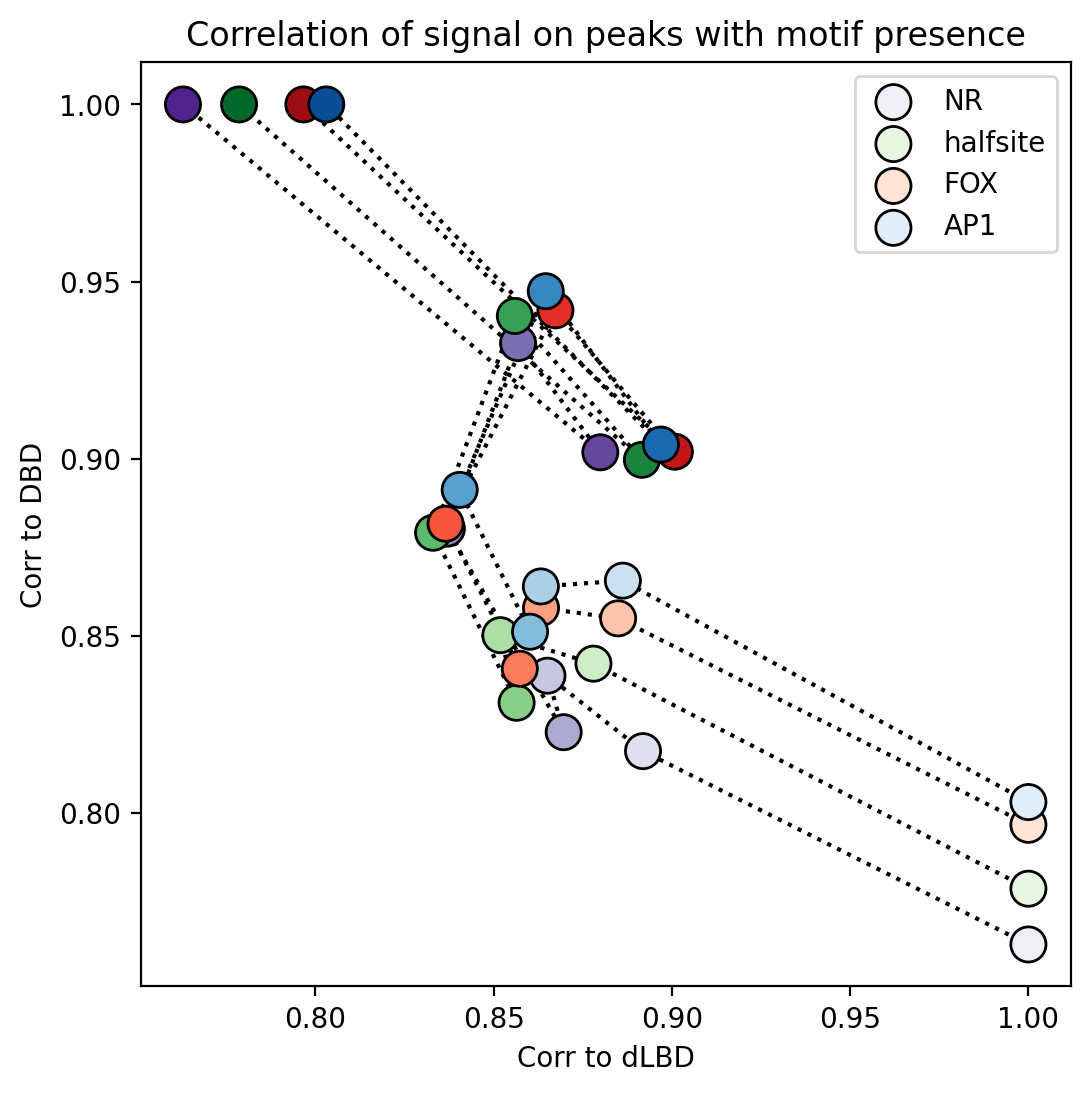

In [43]:
mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_gr_trunc_cluster', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_gr_trunc_cluster',
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_gr_trunc_cluster', 
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_gr_trunc_cluster', ]
mots_enrich = pd.concat([load_and_rename_mot(x, x.split('/')[-1]) for x in mot_folders], axis=1)
clustered_w_motifs = pd.concat([data3.set_index('nindex'), mots_enrich.fillna(0)], axis=1).fillna(0)

fig, ax = plt.subplots(1, figsize=(6,6))

ax.plot(clustered_w_motifs.query("NR_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("NR_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Purples', n_colors=len(labels)), s=160, ec='k', label='NR', zorder=20)


ax.plot(clustered_w_motifs.query("NR_hs_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_hs_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("NR_hs_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("NR_hs_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Greens', n_colors=len(labels)), s=160, ec='k', label='halfsite', zorder=20)

ax.plot(clustered_w_motifs.query("FOX_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("FOX_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("FOX_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("FOX_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Reds', n_colors=len(labels)), s=160, ec='k', label='FOX', zorder=20)

ax.plot(clustered_w_motifs.query("AP1_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("AP1_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1], c='black', ls=':')
ax.scatter(clustered_w_motifs.query("AP1_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,0],
       clustered_w_motifs.query("AP1_nmumg_gr_trunc_cluster>0").loc[:, labels].corr().iloc[:,-1],
           c=sns.color_palette('Blues', n_colors=len(labels)), s=160, ec='k', label='AP1', zorder=20)

ax.legend()
ax.set_xlabel('Corr to dLBD')
ax.set_ylabel('Corr to DBD')
ax.set_title('Correlation of signal on peaks with motif presence')
# ax.set_ylim([0.5,1])
# ax.set_xlim([0.5,1])

fig.savefig('figures/Fig5/signal_corr_w_motifs_gr.pdf')

In [44]:

# mot_signals = sorted(glob.glob('cell_peaks_dbddlbdwtlig/pr_trunc_nmumg_*_signals_on_motifs.parquet'))


# mot_signals = [ 'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_signals_on_motifs.parquet',
#                'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn50_signals_on_motifs.parquet',
#                'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_gr_dlbd_dn100_signals_on_motifs.parquet',
                
#          'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn150_signals_on_motifs.parquet',
#          'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn250_signals_on_motifs.parquet',
#          'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn300_signals_on_motifs.parquet',
#          'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn400_signals_on_motifs.parquet',
#                'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dbd_signals_on_motifs.parquet'
#               ]

# alldf = pd.DataFrame()

# for sig in mot_signals:
#     a = pd.read_parquet(sig)
#     analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))].groupby('id', group_keys=False)\
#     .apply(filter_top_quantile, 0.9).groupby('id').mean().T
#     analyzed.columns = [x+ sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '')\
#                         for x in analyzed.columns]
#     alldf = pd.concat([alldf, analyzed], axis=1)

# fig = plt.figure(figsize=(33,8), constrained_layout=True, dpi=200)    

# subf = fig.subfigures(1,4, width_ratios=[10,2,5,5])

# # fig, ax = plt.subplots(4,9,figsize=(20,8), constrained_layout=True, sharex=False)

# ax = subf[0].subplots(4,len(mot_signals), sharex=False)

# ax= ax

# lens_big_dict = dict()
# enrich_big_dict = dict()

# for i, axrow,c in zip(['NR','halfsite', 'FOX', 'AP1'], ax, ['purple', '#56e15e', 'salmon', '#cee156']):
#         name = alldf.filter(regex=i).columns
        
#         for namei, axcol in zip(name, axrow):
#             ad = alldf.loc[:, namei]
#             enrich_big_dict[namei] = np.log2((ad.iloc[list(np.arange(70,90)) + list(np.arange(110,130))].sum() /\
#     ad.iloc[list(np.arange(0,20)) + list(np.arange(180,200))].sum()))
#             rfunc = lambda x: find_gap_length(x.iloc[np.arange(75,125)], x.iloc[np.arange(75,125)].median())
#             lendict = {namei:rfunc(ad)}
#             lens_big_dict[namei] = lendict
#             axcol.plot(ad,  label=namei, c=c)
#             axcol.set_xticks('')
#             axcol.set_title(namei.split('_signals_on')[0].split('trunc_')[1])
            
# for i in np.arange(len(mot_signals)):
#     ax[1][i].sharey(ax[0][i])
#     ax[2][i].sharey(ax[0][i])
#     ax[3][i].sharey(ax[0][i])
# ax[0][0].set_ylabel("NR")
# ax[1][0].set_ylabel("NR halfsite")
# ax[2][0].set_ylabel("FOX")
# ax[3][0].set_ylabel("AP1")



# len_df = pd.DataFrame(pd.DataFrame(lens_big_dict).mean(axis=1))

# len_df.loc[:,'motif'] = [x[0] for x in len_df.index.str.split('_trunc_')]
# len_df.loc[:, 'tf'] = [x[1] for x in len_df.index.str.split('_trunc_')]
# len_df = len_df.pivot(columns='motif', index='tf', values=0)

# ind = ['hgr_dlbd_signals_on_motifs.parquet',
#        'hgr_dlbd_dn50_signals_on_motifs.parquet',
#     'gr_dlbd_dn100_signals_on_motifs.parquet',
#        'hgr_dlbd_dn150_signals_on_motifs.parquet',
#        'hgr_dlbd_dn250_signals_on_motifs.parquet',
#        'hgr_dlbd_dn300_signals_on_motifs.parquet',
#        'hgr_dlbd_dn400_signals_on_motifs.parquet',
#       'hgr_dbd_signals_on_motifs.parquet',

#        ]
# len_df = len_df.loc[ind, :]


# enrich_df = pd.DataFrame(enrich_big_dict, index=['enrich']).T
# enrich_df.loc[:,'motif'] = [x[0] for x in enrich_df.index.str.split('_trunc_')]
# enrich_df.loc[:, 'tf'] = [x[1] for x in enrich_df.index.str.split('_trunc_')]
# enrich_df = enrich_df.pivot(columns='motif', index='tf', values='enrich')


# enrich_df = enrich_df.loc[ind, :]

# ax= subf[1].subplots(1, )
# sns.heatmap(enrich_df, cmap='GnBu',
#             linewidth=1, linecolor='k', annot=len_df.values, vmin=1, vmax=2, ax=ax)

# ax.set_yticklabels('')

# axfoot, corrax = subf[2].subplots(2,1, sharex=True, )
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_NRgr'], label='NR', c=enrich_df.loc[:, 'GR_NRgr'], cmap='Purples', vmin=1, vmax=2, ec='k', s=120)
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_AP1gr'], label='AP1', c=enrich_df.loc[:, 'GR_AP1gr'], cmap='Blues', vmin=1, vmax=2, ec='k', s=120)
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_FOXgr'], label='FOX', c=enrich_df.loc[:, 'GR_FOXgr'], cmap='Reds', vmin=1, vmax=2, ec='k', s=120)
# axfoot.scatter(len_df.index, len_df.loc[:, 'GR_halfsitegr'], label='halfsite', c=enrich_df.loc[:, 'GR_halfsitegr'], cmap='Greens', vmin=1, vmax=2, ec='k', s=120)


# axfoot.plot(len_df.index, len_df.loc[:, 'GR_NRgr'], c='gray', ls='--', lw=.5)
# axfoot.plot(len_df.index, len_df.loc[:, 'GR_AP1gr'], c='gray', ls='--', lw=.5)
# axfoot.plot(len_df.index, len_df.loc[:, 'GR_FOXgr'], c='gray', ls='--', lw=.5)
# axfoot.plot(len_df.index, len_df.loc[:, 'GR_halfsitegr'], c='gray', ls='--', lw=.5)

# axfoot.legend()
# axfoot.set_xticks(np.arange(len(mot_signals)), ['hgr_dlbd', 'hgr_dlbd_dn50', 'hgr_dlbd_dn100','hgr_dlbd_dn150',
#        'hgr_dlbd_dn250', 'hgr_dlbd_dn300', 'hgr_dlbd_dn400', 'hgr_dbd'], rotation=90)
    

# mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_gr_trunc_cluster', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_gr_trunc_cluster',
# 'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_gr_trunc_cluster', 
# 'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_gr_trunc_cluster', ]
# mots_enrich = pd.concat([load_and_rename_mot(x, x.split('/')[-1]) for x in mot_folders], axis=1)
# clustered_w_motifs = pd.concat([data3.set_index('nindex'), mots_enrich.fillna(0)], axis=1).fillna(0)
# ax = subf[3].subplots(1)
# corr = clustered_w_motifs.query("NR_nmumg_gr_trunc_cluster>0").loc[:, mpeak_fc.index].corr()
# sns.heatmap(corr,
#             cmap='GnBu', ax=ax)
# corrax.scatter(len_df.index, corr.nmumg_hgr_dlbd,c='salmon', s=120)
# corrax.scatter(len_df.index, corr.nmumg_hgr_dbd,c='darkslateblue', s=120)

# corrax.plot(len_df.index, corr.nmumg_hgr_dlbd, c='gray', ls='--')
# corrax.plot(len_df.index, corr.nmumg_hgr_dbd, c='gray', ls='--')

# corrax.set_xticks(np.arange(len(mot_signals)),  ['hgr_dlbd', 'hgr_dlbd_dn50', 'hgr_dlbd_dn100','hgr_dlbd_dn150',
#        'hgr_dlbd_dn250', 'hgr_dlbd_dn300', 'hgr_dlbd_dn400', 'hgr_dbd'], rotation=90)
# #     # fig.savefig('figures/footshape.pdf')

In [45]:
mot_signals = [ 'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_signals_on_motifs.parquet',
               'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn50_signals_on_motifs.parquet',
               'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_gr_dlbd_dn100_signals_on_motifs.parquet',
                
         'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn150_signals_on_motifs.parquet',
         'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn250_signals_on_motifs.parquet',
         'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn300_signals_on_motifs.parquet',
                              'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dbd_signals_on_motifs.parquet',

         'cell_peaks_dbddlbdwtlig/gr_trunc_nmumg_hgr_dlbd_dn400_signals_on_motifs.parquet',
              ]
labels = ['hgr_dlbd', 'hgr_dlbd_dn50', 'hgr_dlbd_dn100','hgr_dlbd_dn150',
       'hgr_dlbd_dn250', 'hgr_dlbd_dn300', 'hgr_dbd', 'nmumg_hgr_dlbd_dn400',]

In [46]:
alldf, allfoot_df = proc_signals(mot_signals)


/tmp/ipykernel_2655030/168397341.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_2655030/168397341.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_2655030/1

/tmp/ipykernel_2655030/1605342044.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


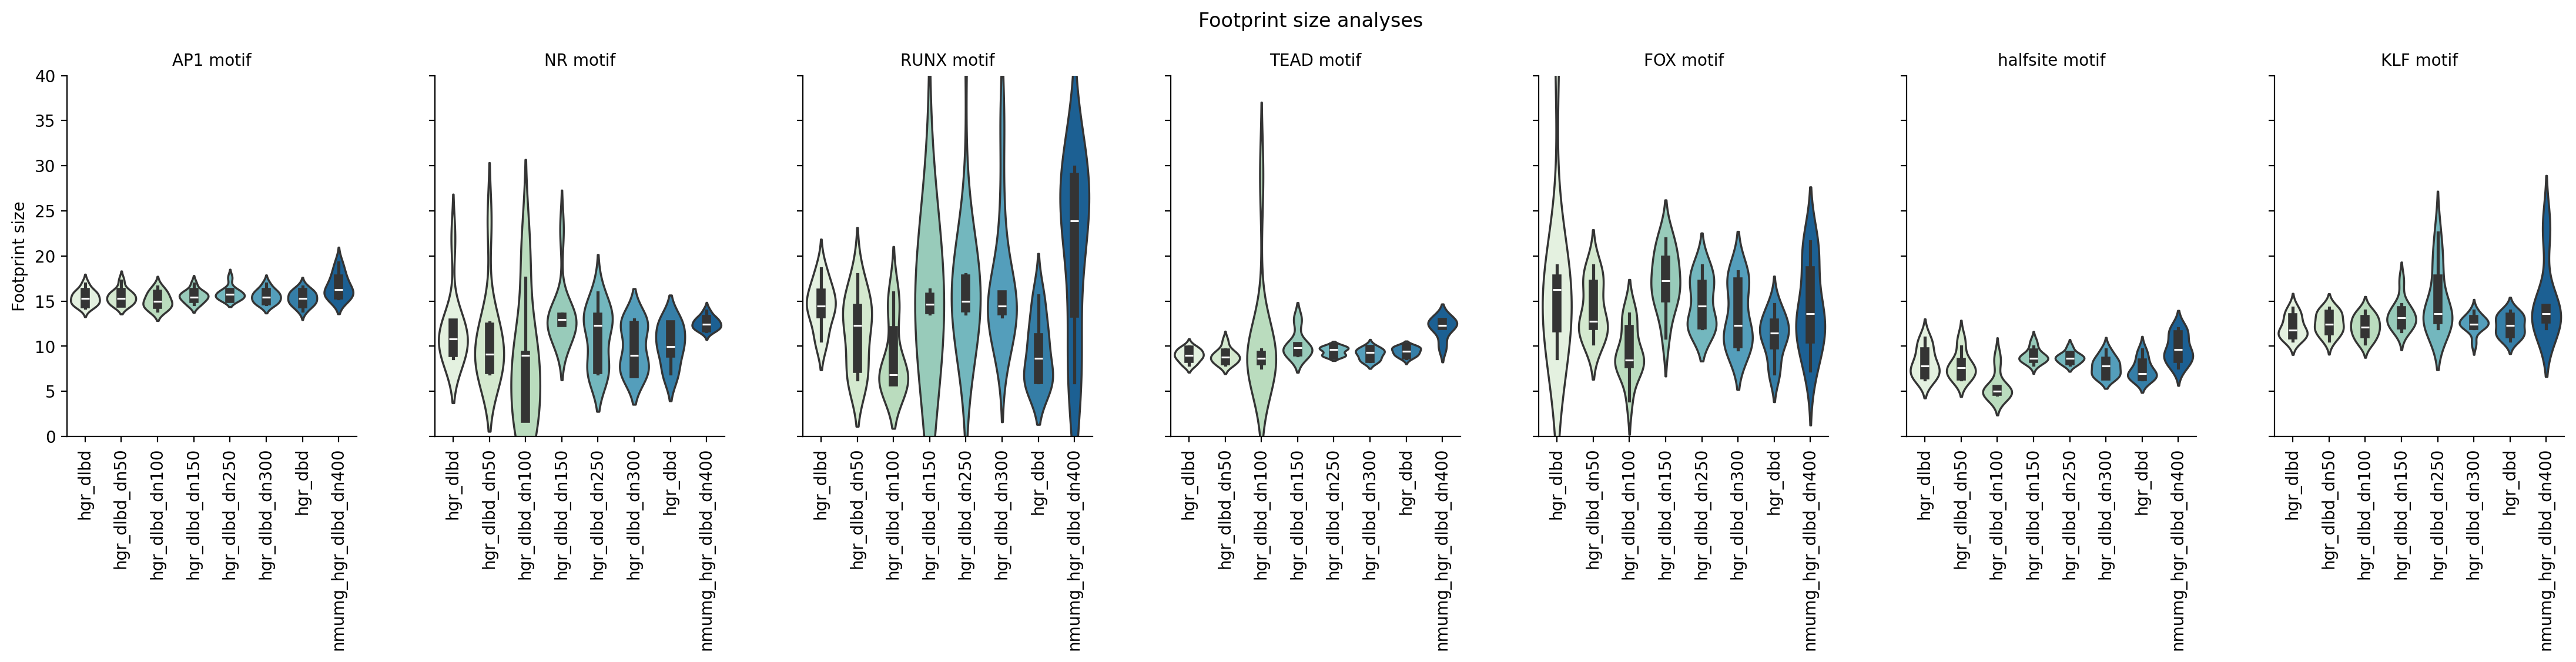

In [47]:
unstacked = allfoot_df.loc[0.3:0.75].unstack().reset_index()
g = plot_foot(allfoot_df.iloc[:10,:], labels)

g.figure.savefig('figures/Fig4/trunc_violins_gr.pdf')

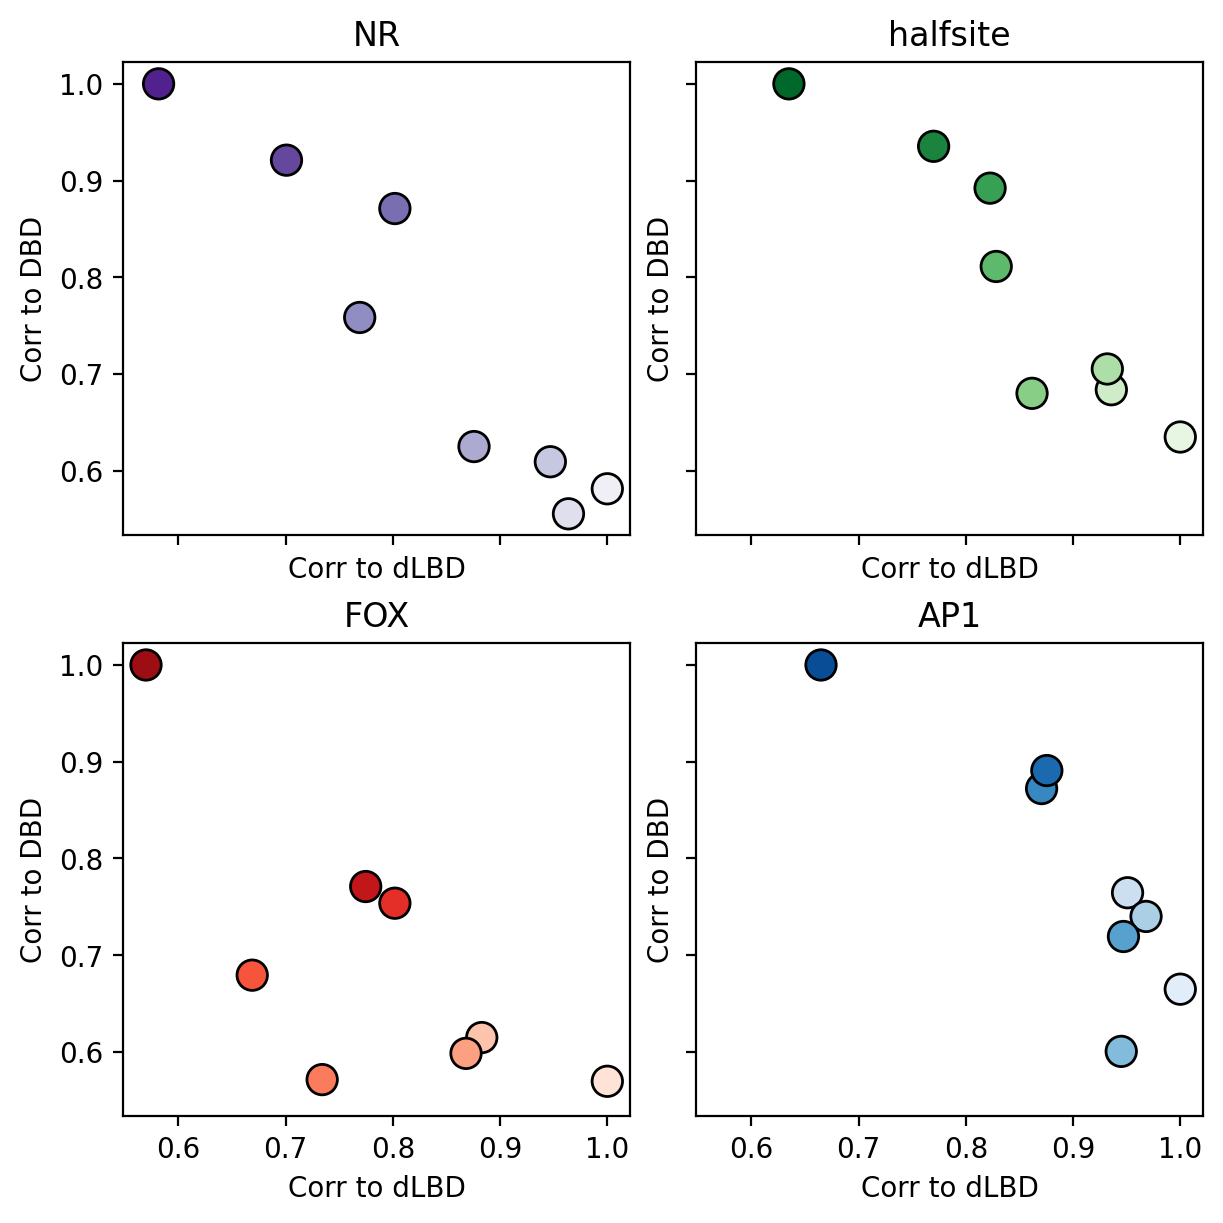

In [48]:
ids=['NR', 'halfsite', 'FOX', 'AP1']

cd = sns.color_palette('Purples', n_colors=len(labels))
all_corr = alldf.corr()

fig, ax = plt.subplots(2,2, sharex=True, sharey=True, constrained_layout=True, figsize=(6,6))
ax= ax.flatten()
ax[0].scatter(alldf.filter(regex=ids[0]).corr().iloc[:, 0], alldf.filter(regex=ids[0]).corr().iloc[:, -1], c=sns.color_palette('Purples', n_colors=len(labels)), s=120, ec='k', label='NR')
ax[1].scatter(alldf.filter(regex=ids[1]).corr().iloc[:, 0], alldf.filter(regex=ids[1]).corr().iloc[:, -1], c=sns.color_palette('Greens', n_colors=len(labels)), s=120, ec='k', label='halfsite')
ax[2].scatter(alldf.filter(regex=ids[2]).corr().iloc[:, 0], alldf.filter(regex=ids[2]).corr().iloc[:, -1], c=sns.color_palette('Reds', n_colors=len(labels)), s=120, ec='k', label='FOX')
ax[3].scatter(alldf.filter(regex=ids[3]).corr().iloc[:, 0], alldf.filter(regex=ids[3]).corr().iloc[:, -1], c=sns.color_palette('Blues', n_colors=len(labels)), s=120, ec='k', label='AP1')

for i, axi in zip(ids, ax):
    axi.set_title(i)
    axi.set_xlabel('Corr to dLBD')
    axi.set_ylabel('Corr to DBD')

fig.savefig('figures/Fig4/trunc_shape_corr_gr.pdf')

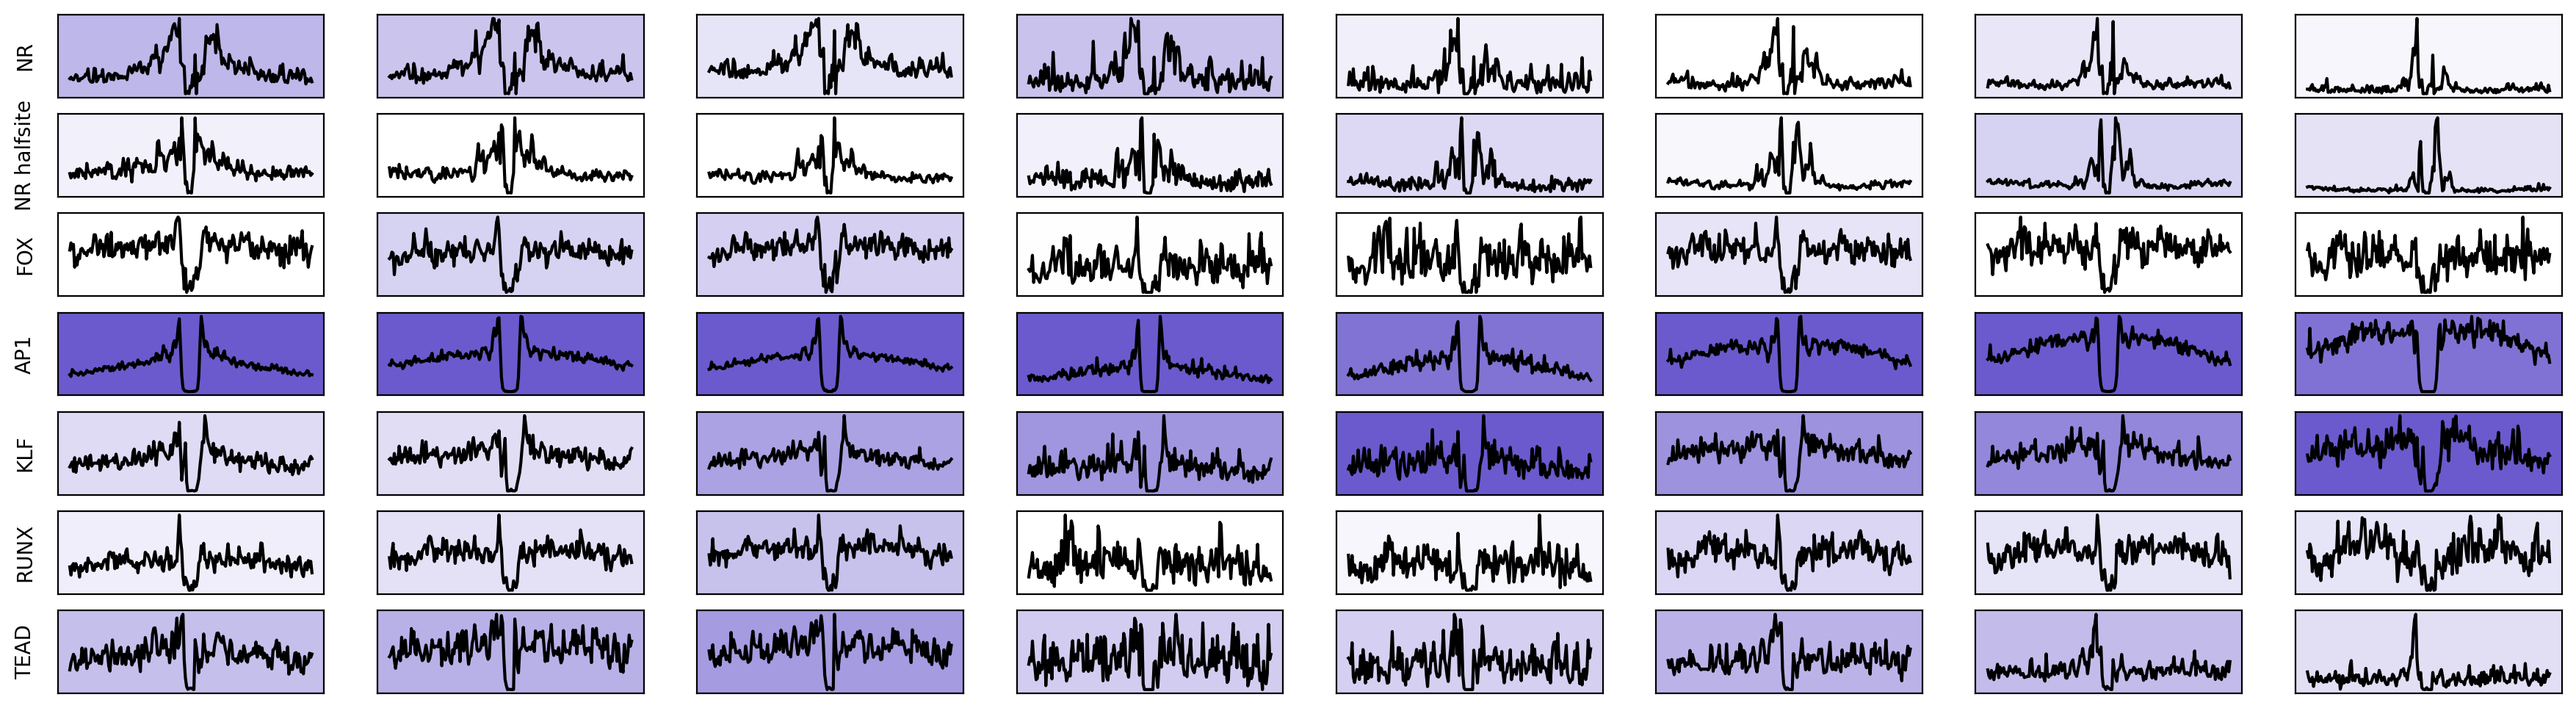

In [49]:
from itertools import repeat
maxesd = dict()
mind = dict()
lim_d = dict()
extend = []
for label in labels:
    extend.extend([label]*7)
label_sampled = pd.DataFrame(dict(zip(alldf.columns, extend)), index=['label']).T.reset_index().groupby('label').agg(lambda x: list(x)).squeeze().to_dict()

for key, values in label_sampled.items():
    max_val = alldf.loc[:, values].mean().max()
    min_val = alldf.loc[:, values].mean().min()

    maxesd.update(dict(zip(values, repeat(max_val))))
    mind.update(dict(zip(values, repeat(min_val))))
    lim_d.update(dict(zip(values, repeat(alldf.loc[:, values].max().max()))))
fig, ax = plt.subplots(7,len(mot_signals), sharex=False, figsize=(22,6))

for i, axrow in zip(['NR','halfsite', 'FOX', 'AP1', 'KLF', 'RUNX', 'TEAD'], ax, ):
    name = alldf.filter(regex=i).columns
    for namei, axcol in zip(name, axrow):
        ad = alldf.loc[:, namei]
        norm = plt.Normalize(vmin=mind[namei], vmax=maxesd[namei])

        
        axcol.plot(ad,  label=namei, c='k')
        # axcol.set_ylim([-2, lim_d[namei]])
        axcol.set_xticks('')
        axcol.set_yticklabels('')
        background_color = colormap(norm(ad.mean()))
        axcol.set_facecolor(background_color)
        axcol.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        if i ==' NR':
            axcol.set_title(namei.split('_signals_on')[0].split('trunc_')[1])
            

ax[0][0].set_ylabel("NR")
ax[1][0].set_ylabel("NR halfsite")
ax[2][0].set_ylabel("FOX")
ax[3][0].set_ylabel("AP1")
ax[4][0].set_ylabel("KLF")
ax[5][0].set_ylabel("RUNX")
ax[6][0].set_ylabel("TEAD")

fig.savefig('figures/Fig4/trunc_motif_means_gr.pdf')
